 # projet 6 : Classifiez automatiquement des biens de consommation

# Etudiez la faisabilité d'un moteur de classification d'articles

## import des librairies et des packages : 

In [1]:
# === IMPORTS DE BASE ===
import sys
import os
import nltk
import warnings
import re 


# Ignorer les warnings
warnings.filterwarnings("ignore")

# === CONFIGURATION DU DOSSIER nltk_data ===
nltk_dir = os.path.join(os.path.expanduser('~'), 'nltk_data')
os.makedirs(nltk_dir, exist_ok=True)
nltk.data.path.append(nltk_dir)

# === INFORMATIONS DEBUG ===
print("✔ Python executable:", sys.executable)
print("✔ NLTK version:", nltk.__version__)
print("✔ Chemin NLTK:", nltk.__file__)
print("✔ Dossier NLTK configuré :", nltk_dir)

# === TÉLÉCHARGEMENT DES RESSOURCES NÉCESSAIRES ===
def safe_download(resource):
    try:
        nltk.data.find(resource)
        print(f"✔ Ressource déjà installée : {resource}")
    except LookupError:
        print(f"⬇ Téléchargement : {resource}")
        nltk.download(resource.split('/')[-1], download_dir=nltk_dir)

safe_download('tokenizers/punkt')
safe_download('corpora/stopwords')
safe_download('corpora/wordnet')
safe_download('corpora/omw-1.4')
# Punkt_tab n'est pas une ressource standard, donc ignorée

# === IMPORTS NLTK UTILES ===
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# === AUTRES IMPORTS NLP ===
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec


# === VÉRIFICATION DE BON FONCTIONNEMENT ===
def verify_nltk():
    test_text = "NLTK is now properly configured!"
    try:
        tokens = word_tokenize(test_text)
        print("✅ NLTK fonctionnel - Tokens:", tokens)
        print("🛠 Stopwords:", stopwords.words('english')[:5])
    except Exception as e:
        print("❌ Erreur NLTK :", str(e))

verify_nltk()


✔ Python executable: C:\Users\mario\.conda\envs\jupyter_env\python.exe
✔ NLTK version: 3.9.1
✔ Chemin NLTK: C:\Users\mario\.conda\envs\jupyter_env\Lib\site-packages\nltk\__init__.py
✔ Dossier NLTK configuré : C:\Users\mario\nltk_data
✔ Ressource déjà installée : tokenizers/punkt
✔ Ressource déjà installée : corpora/stopwords
⬇ Téléchargement : corpora/wordnet
⬇ Téléchargement : corpora/omw-1.4


[nltk_data] Downloading package wordnet to C:\Users\mario\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\mario\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✅ NLTK fonctionnel - Tokens: ['NLTK', 'is', 'now', 'properly', 'configured', '!']
🛠 Stopwords: ['a', 'about', 'above', 'after', 'again']


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

## import du fichier CSV et exploration :

In [3]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv', sep=',')
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

## Exploration du fichier : 

In [4]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [5]:
# Affiche les dimensions du DataFrame
print(f"Dimensions du DataFrame : {df.shape}")

# ✅ Vérifier les doublons
nb_doublons = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {nb_doublons}")

# ✅ Vérifier les NaN par colonne
nan_par_colonne = df.isna().sum()
print("\nValeurs manquantes (NaN) par colonne :")
print(nan_par_colonne)

# ✅ Afficher les lignes contenant au moins un NaN
print("\nExtrait des lignes avec au moins une valeur manquante :")
print(df[df.isna().any(axis=1)].head())


Dimensions du DataFrame : (1050, 15)
Nombre de lignes dupliquées : 0

Valeurs manquantes (NaN) par colonne :
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

Extrait des lignes avec au moins une valeur manquante :
                            uniq_id            crawl_timestamp  \
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
5  893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
6  f355cc1ccb08bd0d283ed979b7ee7515  2015-12-04 07:25:36 +0000   
7  dd0e3470a7e6ed76fd69c2da27721041  2015-12-04 07:25:36 +0000   
8  41384da51732c0b4df3de8f

## suppression des colonnes qui ne vont pas nous servire 

In [6]:
# Supprimer les colonnes innutiles pour mon analyses : 
columns_to_drop = [
    "crawl_timestamp",
    "product_url",
    "pid",
    "retail_price",
    "discounted_price",
    "is_FK_Advantage_product",
    "product_rating",
    "overall_rating",
    "product_specifications"
]

df.drop(columns=columns_to_drop, inplace=True)

In [7]:
df

,uniq_id,product_name,product_category_tree,image,description,brand
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print
...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra


## créer la colonne category : 

In [8]:
# Fonction pour extraire la catégorie principale
def extract_main_category(category_tree):
    """
    Extrait le texte entre le premier '"' et le premier '>'
    Exemple: 
    Input: '["Home & Kitchen > Kitchen & Dining > Cookware"]'
    Output: 'Home & Kitchen'
    """
    if pd.isna(category_tree):
        return None
    
    # Utilisation d'une expression régulière pour trouver le pattern
    match = re.search(r'\"(.+?)\>', category_tree)
    if match:
        return match.group(1).strip()
    return None

# Application à la colonne product_category_tree
df['category'] = df['product_category_tree'].apply(extract_main_category)


In [9]:
# Vérification des résultats
print("🔍 Exemples de catégories extraites :")
print(df[['product_category_tree', 'category']].head())

# Statistiques
print("\n📊 Nombre de catégories uniques :", df['category'].nunique())
print("Top 5 catégories :\n", df['category'].value_counts().head())

🔍 Exemples de catégories extraites :
                               product_category_tree         category
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing

📊 Nombre de catégories uniques : 7
Top 5 catégories :
 category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Name: count, dtype: int64


In [10]:
df['category'].value_counts()

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [11]:
df

,uniq_id,product_name,product_category_tree,image,description,brand,category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing
...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra,Baby Care
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra,Baby Care


## Prétraitement des données texte : dans le colonne "description"

In [12]:
pd.set_option('display.max_colwidth', None)
df['description'].head(5) 

0    Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that

## CE1: Nettoyage des champs de texte

In [13]:
import re
from nltk.corpus import stopwords
import pandas as pd

# Télécharger les stopwords si nécessaire
import nltk
nltk.download('stopwords')

# Fonction de nettoyage améliorée
def clean_text(text):
    """
    Nettoie le texte en:
    1. Convertissant en minuscules
    2. Supprimant la ponctuation
    3. Supprimant les stopwords
    4. Supprimant les chiffres
    """
    if not isinstance(text, str):
        return ""
    
    # Mise en minuscules
    text = text.lower()
    
    # Suppression de la ponctuation ET des chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Ponctuation
    text = re.sub(r'\d+', '', text)       # Chiffres
    
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))  # Adaptez la langue
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

# Appliquer le nettoyage
df['cleaned_description'] = df['description'].apply(clean_text)

### 🔢 Comptage des mots, stopwords et chiffres supprimés ###
def count_words(text):
    """Compte les mots dans un texte"""
    return len(str(text).split()) if str(text) != '' else 0

def count_stopwords(text):
    """Compte les stopwords dans un texte"""
    if not isinstance(text, str):
        return 0
    stop_words = set(stopwords.words('english'))
    words = text.lower().split()
    return sum(1 for word in words if word in stop_words)

def count_digits(text):
    """Compte les chiffres dans un texte"""
    return len(re.findall(r'\d', str(text)))

# Calculs
df['nb_mots_description'] = df['description'].apply(count_words)
df['nb_mots_cleaned'] = df['cleaned_description'].apply(count_words)
df['nb_stopwords_supprimes'] = df['description'].apply(count_stopwords) - df['cleaned_description'].apply(count_stopwords)
df['nb_chiffres_supprimes'] = df['description'].apply(count_digits)

# Résultat
print("Aperçu du nettoyage :")
display(df[['description', 'cleaned_description']].head())

print("\nStatistiques de nettoyage :")
display(df[['nb_mots_description', 'nb_mots_cleaned', 'nb_stopwords_supprimes', 'nb_chiffres_supprimes']].describe())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Aperçu du nettoyage :


,description,cleaned_description
0,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",key features elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price rs curtain enhances look interiorsthis curtain made high quality polyester fabricit features eyelet style stitch metal ringit makes room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimensions length cm box number contents sales package pack sales package curtains body design material polyester
1,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model id asvtwl color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel
2,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to sh


Statistiques de nettoyage :


,nb_mots_description,nb_mots_cleaned,nb_stopwords_supprimes,nb_chiffres_supprimes
count,1050.000000,1050.000000,1050.000000,1050.000000
mean,76.202857,52.542857,17.932381,12.977143
std,74.851233,47.872254,25.528918,12.156802
min,13.000000,12.000000,0.000000,0.000000
25%,30.000000,22.000000,5.000000,5.000000
50%,44.000000,33.000000,7.000000,10.000000
75%,94.000000,70.750000,18.000000,17.000000
max,587.000000,367.000000,211.000000,90.000000


## CE2: Fonction de tokenisation

In [14]:
# Fonction de tokenisation
def tokenize_sentence(sentence):
    """Tokenise une phrase en mots individuels"""
    return word_tokenize(sentence) if isinstance(sentence, str) else []

# Application à la colonne 'cleaned_description'
df['tokens'] = df['cleaned_description'].apply(tokenize_sentence)

# Affichage des résultats
df[['cleaned_description', 'tokens']].head()

,cleaned_description,tokens
0,key features elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price rs curtain enhances look interiorsthis curtain made high quality polyester fabricit features eyelet style stitch metal ringit makes room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimensions length cm box number contents sales package pack sales package curtains body design material polyester,"[key, features, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, features, eyelet, style, stitch, metal, ringit, makes, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, designs, surreal, attention, sure, steal, hearts, contemporary, eyelet, valance, curtains, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, rays, want, wish, good, morning, whole, world, draw, close, evening, create, special, moments, joyous, beauty, given, soothing, prints, bring, home, elegant, curtain, softly, filters, light, room, ...]"
1,specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model id asvtwl color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel,"[specifications, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, features, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, women, boys, girls, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimensions, length, inch, width, inch, box, number, contents, sales, package, sales, package, bath, towel]"
2,key features eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price rs eurospa brings exclusively designed soft cotton towels export quality products soft texture takes care skin gives enriched feeling deserve eurospa exporting bath towels lot renowned brands last years famous fine prints absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary wash care wash cold water iron bleach flat dry wash first use size face towel cms x cmsspecifications eurospa cotton terry face towel set piece face towel set assorted bath towel features material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvampcftsetassorted ideal boys girls men women model id shuvampcftsetassorted size small color assorted dimensions weight g length inch width inch box number contents sales package sales package piece face towel set,"[key, features, eurospa, cotton, terry, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, set, piece, face, towel, set, assorted, price, rs

## CE3: Fonction de stemming

In [15]:
from nltk.stem import PorterStemmer

# Fonction modifiée pour recevoir une liste de tokens
def stem_tokens(tokens):
    """Applique le stemming sur une liste de mots déjà tokenisés"""
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]
    
df['stems'] = df['tokens'].apply(stem_tokens)
df[['tokens', 'stems']].head()


,tokens,stems
0,"[key, features, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, features, eyelet, style, stitch, metal, ringit, makes, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, designs, surreal, attention, sure, steal, hearts, contemporary, eyelet, valance, curtains, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, rays, want, wish, good, morning, whole, world, draw, close, evening, create, special, moments, joyous, beauty, given, soothing, prints, bring, home, elegant, curtain, softly, filters, light, room, ...]","[key, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtaineleg, polyest, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhanc, look, interiorsthi, curtain, made, high, qualiti, polyest, fabricit, featur, eyelet, style, stitch, metal, ringit, make, room, environ, romant, lovingthi, curtain, ant, wrinkl, anti, shrinkag, eleg, apparanceg, home, bright, modernist, appeal, design, surreal, attent, sure, steal, heart, contemporari, eyelet, valanc, curtain, slide, smoothli, draw, apart, first, thing, morn, welcom, bright, sun, ray, want, wish, good, morn, whole, world, draw, close, even, creat, special, moment, joyou, beauti, given, sooth, print, bring, home, eleg, curtain, softli, filter, light, room, ...]"
1,"[specifications, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, features, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, women, boys, girls, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimensions, length, inch, width, inch, box, number, contents, sales, package, sales, package, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, featur, machin, washabl, ye, materi, cotton, design, self, design, gener, brand, sathiya, type, bath, towel, gsm, model, name, sathiya, cotton, bath, towel, ideal, men, women, boy, girl, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimens, length, inch, width, inch, box, number, content, sale, packag, sale, packag, bath, towel]"
2,"[key, features, eurospa, cotton, terry, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, set, piece, face, towel, set, assorted, price, rs, eurospa, brings, exclusively, designed, soft, cotton, towels, export, quality, products, soft, texture, takes, care, skin, gives, enriched, feeling, deserve, eurospa, exporting, bath, towels, lot, renowned, brands, last, years, famous, fine, prints, absorbency, softness, durability, note, product, cotton, susceptible, shrinkage, product, color, may, vary, picture, size, may, vary, wash, care, wash, cold, water, iron, bleach, flat, dry, wash, first, use, size, face, towel, cms, x, cmsspecifications, eurospa, cotton, terry, face, towel, set, piece, face, towel, ...]","[key, featur, eurospa, cotton, terri, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terri, face, towel, set, piec, face, towel, set, assort, price, rs, eurospa, bring, exclus, design, soft, cotton, towel, export, qualiti, product, soft, textur, take, care, skin, give, enrich, feel, deserv, eurospa, export, bath, towel, lot, renown, brand, last, year, famou, fine, print, absorb, soft, durabl, note, product, cotton, suscept, shrinkag, product, color, may, vari, pictur, size, may, vari, wash, care, wash, cold, water, iron, bleach, flat, dri, wash, first, use, size, face, towel, cm, x, cmsspecif, eurospa, cotton, terri, face, towel, set, piec, face, towel, ...]"
3,"[key, features, sa

le stemming n'est pas précis, il vient tronquer des mots de maniéres aléatoires et finalement ca n'as plus de sens, je pense que  je ne devrais pas utiliser le stemming pour essayer de faire un model supervisé 

## CE4: Fonction de lemmatisation

In [16]:
from nltk.stem import WordNetLemmatizer

# Fonction de lemmatisation adaptée
def lemmatize_tokens(tokens):
    """Applique la lemmatisation à une liste de tokens"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Application au DataFrame
df['lemmas'] = df['tokens'].apply(lemmatize_tokens)

# Affichage
df[['tokens', 'lemmas']].head()


,tokens,lemmas
0,"[key, features, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, features, eyelet, style, stitch, metal, ringit, makes, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, designs, surreal, attention, sure, steal, hearts, contemporary, eyelet, valance, curtains, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, rays, want, wish, good, morning, whole, world, draw, close, evening, create, special, moments, joyous, beauty, given, soothing, prints, bring, home, elegant, curtain, softly, filters, light, room, ...]","[key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, r, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, feature, eyelet, style, stitch, metal, ringit, make, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, design, surreal, attention, sure, steal, heart, contemporary, eyelet, valance, curtain, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, ray, want, wish, good, morning, whole, world, draw, close, evening, create, special, moment, joyous, beauty, given, soothing, print, bring, home, elegant, curtain, softly, filter, light, room, ...]"
1,"[specifications, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, features, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, women, boys, girls, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimensions, length, inch, width, inch, box, number, contents, sales, package, sales, package, bath, towel]","[specification, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, feature, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"
2,"[key, features, eurospa, cotton, terry, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, set, piece, face, towel, set, assorted, price, rs, eurospa, brings, exclusively, designed, soft, cotton, towels, export, quality, products, soft, texture, takes, care, skin, gives, enriched, feeling, deserve, eurospa, exporting, bath, towels, lot, renowned, brands, last, years, famous, fine, prints, absorbency, softness, durability, note, product, cotton, susceptible, shrinkage, product, color, may, vary, picture, size, may, vary, wash, care, wash, cold, water, iron, bleach, flat, dry, wash, first, use, size, face, towel, cms, x, cmsspecifications, eurospa, cotton, terry, face, towel, set, piece, face, towel, ...]","[key, feature, eurospa, cotton, terry, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, set, piece, face, towel, set, assorted, price, r, eurospa, brings, exclusively, designed, soft, cotton, towel, export, quality, product, soft, texture, take, care, skin, give, enriched, feeling, deserve, eurospa, exporting, bath, towel, lot, renowned, brand, last, year, famous, fine, print, absorbency, softness, durability, note, product, cotton, susceptible, shrinkage, product, color, may, vary, picture, size, may, vary, wash, care, wash, cold, water, iron, bleach, flat, dry, wash, first, use, si

On va utiliser la lemmatisation car elle est plus précise : 

In [17]:
# Calcul du nombre de tokens et lemmes
df['nb_tokens'] = df['tokens'].apply(len)
df['nb_lemmas'] = df['lemmas'].apply(len)

# Calcul des différences
df['diff_token_lemma'] = df['nb_tokens'] - df['nb_lemmas']

# Statistiques globales
stats = {
    "Moyenne tokens": df['nb_tokens'].mean(),
    "Moyenne lemmes": df['nb_lemmas'].mean(),
    "Réduction moyenne": df['diff_token_lemma'].mean(),
    "Cas où nb_lemmas < nb_tokens": (df['diff_token_lemma'] > 0).sum(),
    "Cas identiques": (df['diff_token_lemma'] == 0).sum()
}

# Affichage des résultats
print("Statistiques de comparaison :")
for k, v in stats.items():
    print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}")

# Aperçu des données
display(df[['tokens', 'lemmas', 'nb_tokens', 'nb_lemmas', 'diff_token_lemma']].head())

Statistiques de comparaison :
Moyenne tokens: 52.54
Moyenne lemmes: 52.54
Réduction moyenne: 0.00
Cas où nb_lemmas < nb_tokens: 0
Cas identiques: 1050


,tokens,lemmas,nb_tokens,nb_lemmas,diff_token_lemma
0,"[key, features, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, features, eyelet, style, stitch, metal, ringit, makes, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, designs, surreal, attention, sure, steal, hearts, contemporary, eyelet, valance, curtains, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, rays, want, wish, good, morning, whole, world, draw, close, evening, create, special, moments, joyous, beauty, given, soothing, prints, bring, home, elegant, curtain, softly, filters, light, room, ...]","[key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, r, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, feature, eyelet, style, stitch, metal, ringit, make, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, design, surreal, attention, sure, steal, heart, contemporary, eyelet, valance, curtain, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, ray, want, wish, good, morning, whole, world, draw, close, evening, create, special, moment, joyous, beauty, given, soothing, print, bring, home, elegant, curtain, softly, filter, light, room, ...]",149,149,0
1,"[specifications, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, features, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, women, boys, girls, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimensions, length, inch, width, inch, box, number, contents, sales, package, sales, package, bath, towel]","[specification, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, feature, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, asvtwl, color, red, yellow, blue, size, mediam, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]",62,62,0
2,"[key, features, eurospa, cotton, terry, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, set, piece, face, towel, set, assorted, price, rs, eurospa, brings, exclusively, designed, soft, cotton, towels, export, quality, products, soft, texture, takes, care, skin, gives, enriched, feeling, deserve, eurospa, exporting, bath, towels, lot, renowned, brands, last, years, famous, fine, prints, absorbency, softness, durability, note, product, cotton, susceptible, shrinkage, product, color, may, vary, picture, size, may, vary, wash, care, wash, cold, water, iron, bleach, flat, dry, wash, first, use, size, face, towel, cms, x, cmsspecifications, eurospa, cotton, terry, face, towel, set, piece, face, towel, ...]","[key, feature, eurospa, cotton, terry, face, towel, set, size, small, height, inch, gsm, eurospa, cotton, terry, face, towel, set, piece, face, towel, set, assorted, price, r, eurospa, brings, exclusively, designed, soft, cotton, towel, export, quality, product, soft, texture, take, care, skin, give, enriched, feeling, deserve, eurospa, exporting, bath, towel, lot, renowned, brand, last, year, famous, fine, print, absorbency, softness, durability, note, product, cotton, susceptible, shrinkage, product, color, may, vary, picture, size, may, vary, wash, care, wash, col

In [18]:
df.head(1)

,uniq_id,product_name,product_category_tree,image,description,brand,category,cleaned_description,nb_mots_description,nb_mots_cleaned,nb_stopwords_supprimes,nb_chiffres_supprimes,tokens,stems,lemmas,nb_tokens,nb_lemmas,diff_token_lemma
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",Elegance,Home Furnishing,key features elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price rs curtain enhances look interiorsthis curtain made high quality polyester fabricit features eyelet style stitch metal ringit makes room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimensions length cm box number contents sales package pack sales package curtains body design material polyester,230,149,70,22,"[key, features, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtainelegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, pack, price, rs, curtain, enhances, look, interiorsthis, curtain, made, high, quality, polyester, fabricit, features, eyelet, style, stitch, metal, ringit, makes, room, environment, romantic, lovingthis, curtain, ant, wrinkle, anti, shrinkage, elegant, apparancegive, home, bright, modernistic, appeal, designs, surreal, attention, sure, steal, hearts, contemporary, eyelet, valance, curtains, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, rays, want, wish, good, morning, whole, world, draw, close, evening, create, special, moments, joyous, beauty, given, soothing, prints, bring, home, elegant, curtain, softly, filters, light, room, ...]","[key, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtaineleg, polyest, multi

## CE5: Feature Engineering - Bag-of-Words et TF-IDF

In [19]:
# Fonction pour traiter les lemmes déjà tokenisés (retourne la liste telle quelle)
def identity_tokenizer(text):
    return text

# Bag-of-Words (BoW)
count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.7,
    tokenizer=identity_tokenizer,  # On utilise les tokens tels quels
    preprocessor=lambda x: x,      # Pas de prétraitement supplémentaire
    token_pattern=None             # Désactive le filtrage par regex
)
bow_features = count_vectorizer.fit_transform(df['lemmas'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.7,
    norm='l2',
    tokenizer=identity_tokenizer,  # Même approche
    preprocessor=lambda x: x,
    token_pattern=None
)
tfidf_features = tfidf_vectorizer.fit_transform(df['lemmas'])

# DataFrames pour visualisation
bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [20]:
bow_df

,absorbent,abstract,ac,accessory,actual,adapter,add,addition,additional,adidas,...,world,would,wrap,x,year,yellow,yes,yet,ym,youre
0,0,4,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
tfidf_df

,absorbent,abstract,ac,accessory,actual,adapter,add,addition,additional,adidas,...,world,would,wrap,x,year,yellow,yes,yet,ym,youre
0,0.0,0.198684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.066529,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.198499,0.076520,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.043004,0.049114,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.043566,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.036264,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1046,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.121656,0.0,0.0,0.080851,0.000000,0.000000,0.000000,0.0,0.0,0.0
1047,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


## CE6: Test avec un exemple

In [22]:
# Exemple : un avis en anglais
data = {
    'description': [
        """In our school, the school administration ensures that school activities are planned by the school staff for the benefit of all students. The school curriculum is designed by the school board in accordance with the school district’s policies. Every school day, school buses bring students to school grounds where school teachers provide school education. The school values are shared during school meetings and school programs. In this school system, the school plays an important role in shaping the school life of students."""
    ]
}
df_exemple = pd.DataFrame(data)

# ------------------------------------
# Fonction de nettoyage
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_exemple['cleaned_description'] = df_exemple['description'].apply(clean_text)

# ------------------------------------
# Tokenisation
def tokenize_sentence(sentence):
    return word_tokenize(sentence) if isinstance(sentence, str) else []

df_exemple['tokens'] = df_exemple['cleaned_description'].apply(tokenize_sentence)

# ------------------------------------
# Stemming
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

df_exemple['stems'] = df_exemple['tokens'].apply(stem_tokens)

# Résultat du stemming vs tokens
print("STEMMING (moins précis):")
display(df_exemple[['tokens', 'stems']])

# ------------------------------------
# Lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

df_exemple['lemmas'] = df_exemple['tokens'].apply(lemmatize_tokens)

# Comparaison tokens vs lemmas
print("LEMMATISATION (plus propre) :")
display(df_exemple[['tokens', 'lemmas']])

# ------------------------------------
# Statistiques de taille
df_exemple['nb_tokens'] = df_exemple['tokens'].apply(len)
df_exemple['nb_lemmas'] = df_exemple['lemmas'].apply(len)
df_exemple['diff_token_lemma'] = df_exemple['nb_tokens'] - df['nb_lemmas']

print("COMPARAISON :")
display(df_exemple[['nb_tokens', 'nb_lemmas', 'diff_token_lemma']])

# Bag-of-Words & TF-IDF
def identity_tokenizer(text):
    return text

count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=1,
    max_df=1.0,
    tokenizer=identity_tokenizer,
    preprocessor=lambda x: x,
    token_pattern=None
)

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=1,
    max_df=1.0,
    tokenizer=identity_tokenizer,
    preprocessor=lambda x: x,
    token_pattern=None
)

bow_features = count_vectorizer.fit_transform(df_exemple['lemmas'])
tfidf_features = tfidf_vectorizer.fit_transform(df_exemple['lemmas'])

bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("Bag of Words (BoW) :")
display(bow_df)

print("TF-IDF :")
display(tfidf_df)


STEMMING (moins précis):


,tokens,stems
0,"[school, school, administration, ensures, school, activities, planned, school, staff, benefit, students, school, curriculum, designed, school, board, accordance, school, districts, policies, every, school, day, school, buses, bring, students, school, grounds, school, teachers, provide, school, education, school, values, shared, school, meetings, school, programs, school, system, school, plays, important, role, shaping, school, life, students]","[school, school, administr, ensur, school, activ, plan, school, staff, benefit, student, school, curriculum, design, school, board, accord, school, district, polici, everi, school, day, school, buse, bring, student, school, ground, school, teacher, provid, school, educ, school, valu, share, school, meet, school, program, school, system, school, play, import, role, shape, school, life, student]"


LEMMATISATION (plus propre) :


,tokens,lemmas
0,"[school, school, administration, ensures, school, activities, planned, school, staff, benefit, students, school, curriculum, designed, school, board, accordance, school, districts, policies, every, school, day, school, buses, bring, students, school, grounds, school, teachers, provide, school, education, school, values, shared, school, meetings, school, programs, school, system, school, plays, important, role, shaping, school, life, students]","[school, school, administration, ensures, school, activity, planned, school, staff, benefit, student, school, curriculum, designed, school, board, accordance, school, district, policy, every, school, day, school, bus, bring, student, school, ground, school, teacher, provide, school, education, school, value, shared, school, meeting, school, program, school, system, school, play, important, role, shaping, school, life, student]"


COMPARAISON :


,nb_tokens,nb_lemmas,diff_token_lemma
0,51,51,-98.0


Bag of Words (BoW) :


,accordance,activity,administration,benefit,board,bring,bus,curriculum,day,designed,...,provide,role,school,shaping,shared,staff,student,system,teacher,value
0,1,1,1,1,1,1,1,1,1,1,...,1,1,18,1,1,1,3,1,1,1


TF-IDF :


,accordance,activity,administration,benefit,board,bring,bus,curriculum,day,designed,...,provide,role,school,shaping,shared,staff,student,system,teacher,value
0,0.052486,0.052486,0.052486,0.052486,0.052486,0.052486,0.052486,0.052486,0.052486,0.052486,...,0.052486,0.052486,0.944755,0.052486,0.052486,0.052486,0.157459,0.052486,0.052486,0.052486


## test avec un exemple du data frame 

In [23]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Texte de test
test_text = "key, feature, polyester, multicolor, abstract, eyelet, door, curtain, floral, polyester, multicolor, abstract, eyelet, door, curtain, height, pack, curtain, look, curtain, made, high, quality, polyester, feature, eyelet, style, make, room, curtain, elegant, home, design, sure, eyelet, curtain, good, special, beauty, print, bring, home, elegant, curtain, light, room, get, polyester, multicolor, abstract, eyelet, door, curtain, height, pack, general, brand, designed, door, type, eyelet, model, name, abstract, polyester, door, curtain, set, model, id, color, multicolor, dimension, length, box, number, content, sale, package, pack, sale, package, curtain, body, design, material, polyester"


# Vectorisation 
# Pour l'exemple, créons des vectoriseurs et entraînons-les sur le texte
count_vectorizer = CountVectorizer().fit([test_text])
tfidf_vectorizer = TfidfVectorizer().fit([test_text])

# Bag-of-Words
bow_test = count_vectorizer.transform([test_text])
print(f"BoW features shape: {bow_test.shape}")
print(f"BoW features (non-zero): {bow_test.nnz}")  # Nombre d'éléments non nuls
print(f"Vocabulaire BoW: {count_vectorizer.get_feature_names_out()}")

# TF-IDF
tfidf_test = tfidf_vectorizer.transform([test_text])
print(f"\nTF-IDF features shape: {tfidf_test.shape}")
print(f"TF-IDF features (non-zero): {tfidf_test.nnz}")
print(f"Vocabulaire TF-IDF: {tfidf_vectorizer.get_feature_names_out()}")

BoW features shape: (1, 47)
BoW features (non-zero): 47
Vocabulaire BoW: ['abstract' 'beauty' 'body' 'box' 'brand' 'bring' 'color' 'content'
 'curtain' 'design' 'designed' 'dimension' 'door' 'elegant' 'eyelet'
 'feature' 'floral' 'general' 'get' 'good' 'height' 'high' 'home' 'id'
 'key' 'length' 'light' 'look' 'made' 'make' 'material' 'model'
 'multicolor' 'name' 'number' 'pack' 'package' 'polyester' 'print'
 'quality' 'room' 'sale' 'set' 'special' 'style' 'sure' 'type']

TF-IDF features shape: (1, 47)
TF-IDF features (non-zero): 47
Vocabulaire TF-IDF: ['abstract' 'beauty' 'body' 'box' 'brand' 'bring' 'color' 'content'
 'curtain' 'design' 'designed' 'dimension' 'door' 'elegant' 'eyelet'
 'feature' 'floral' 'general' 'get' 'good' 'height' 'high' 'home' 'id'
 'key' 'length' 'light' 'look' 'made' 'make' 'material' 'model'
 'multicolor' 'name' 'number' 'pack' 'package' 'polyester' 'print'
 'quality' 'room' 'sale' 'set' 'special' 'style' 'sure' 'type']


In [24]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# import pandas as pd

# Supposons que df est votre DataFrame et filtered_lemmas est une colonne de listes de mots
# Exemple avec la première ligne
first_row_lemmas = df['lemmas'].iloc[0]

# Conversion en texte (chaîne de mots séparés par des espaces)
corpus = [' '.join(first_row_lemmas)]

# Vectorisation avec paramètres optimisés
count_vectorizer = CountVectorizer(min_df=1, token_pattern=r'(?u)\b\w+\b')
bow = count_vectorizer.fit_transform(corpus)

tfidf_vectorizer = TfidfVectorizer(min_df=1, token_pattern=r'(?u)\b\w+\b')
tfidf = tfidf_vectorizer.fit_transform(corpus)

# Résultats
print("🔍 Première ligne analysée:")
print("Original:", df['lemmas'].iloc[0])
print("\n🎯 Bag-of-Words (BoW):")
print(pd.DataFrame(bow.toarray(), columns=count_vectorizer.get_feature_names_out()))

print("\n🎯 TF-IDF:")
print(pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out()))

# Statistiques
print("\n📊 Stats:")
print(f"Nombre de mots uniques: {len(count_vectorizer.get_feature_names_out())}")
print(f"Mots les plus fréquents: {dict(zip(count_vectorizer.get_feature_names_out(), bow.toarray()[0]))}")

🔍 Première ligne analysée:
Original: ['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabricit', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'make', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 

## CE7: Word/Sentence Embedding


### Word2Vec

In [25]:
"""
Pipeline complet et propre pour :
1) entraîner Word2Vec à partir de df['lemmas'] (liste de listes de mots)
2) agréger des embeddings par document (moyenne)
3) clusteriser (KMeans) et évaluer (ARI si df['category'] existe)
4) projeter (PCA & t-SNE) et tracer
5) produire matrices de contingence et exporter les résultats

Pré-requis colonnes du DataFrame :
- df['lemmas'] : list[list[str]]  (tokens lemmatisés par document)
- df['category'] : optionnel (catégorie vraie)

Exemple d'appel :
    results = run_pipeline(df)

Le dictionnaire `results` retourne :
- 'model' (Word2Vec), 'X' (np.ndarray), 'kmeans', 'cluster_labels',
- 'ari' (ou None), 'interpretation' (ou None),
- 'pca' (objet), 'pca_coords', 'tsne_coords',
- 'contingency_table', 'contingency_pct' (ou None),
- chemins des fichiers écrits.
"""
from __future__ import annotations

import warnings
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt


# ===============================
# 0) CONFIGURATION
# ===============================
@dataclass
class Config:
    # Word2Vec
    vector_size: int = 100
    window: int = 5
    min_count: int = 3
    workers: int = 4
    sg: int = 1  # 1 = Skip-gram, 0 = CBOW
    epochs: int = 30

    # KMeans / TSNE
    n_clusters: Optional[int] = None  # si None et 'category' dispo ➜ nb catégories uniques
    random_state: int = 42
    n_init: int = 10
    tsne_perplexity: int = 30
    tsne_iter: int = 1000

    # I/O
    path_fig_projection: str = "comparison_pca_tsne_true_vs_kmeans.png"
    path_fig_contingency: str = "contingency_matrix_detailed.png"
    path_csv_results: str = "clustering_analysis_results.csv"


# ===============================
# 1) OUTILS & VALIDATION
# ===============================

def _check_dataframe(df: pd.DataFrame) -> None:
    if 'lemmas' not in df.columns:
        raise ValueError("Le DataFrame doit contenir une colonne 'lemmas' (listes de tokens par document).")
    # Vérif rapide du premier élément
    if len(df) == 0:
        raise ValueError("Le DataFrame est vide.")
    sample = df['lemmas'].iloc[0]
    if not isinstance(sample, (list, tuple)):
        raise TypeError("df['lemmas'] doit contenir des listes de chaînes (tokens).")


def _info_head(df: pd.DataFrame) -> None:
    print("🔍 Vérification des données…")
    print(f"Nombre de lignes : {len(df)}")
    try:
        print("Exemple de lemmas :", df['lemmas'].iloc[0][:5])
    except Exception:
        print("Impossible d'afficher un exemple de lemmas.")


# ===============================
# 2) WORD2VEC & FEATURES DOCUMENTAIRES
# ===============================

def train_word2vec(sentences, cfg: Config) -> Word2Vec:
    print("\n🛠 Entraînement du modèle Word2Vec…")
    model = Word2Vec(
        sentences=sentences,
        vector_size=cfg.vector_size,
        window=cfg.window,
        min_count=cfg.min_count,
        workers=cfg.workers,
        sg=cfg.sg,
        epochs=cfg.epochs,
    )
    print("\n🔎 Exploration rapide du modèle :")
    print(f"Taille du vocabulaire : {len(model.wv.key_to_index)} mots")
    return model


def document_vector(model: Word2Vec, doc) -> np.ndarray:
    """Moyenne des vecteurs de mots présents dans le vocabulaire du modèle."""
    tokens = [w for w in doc if w in model.wv.key_to_index]
    if not tokens:
        return np.zeros(model.vector_size, dtype=np.float32)
    return np.mean(model.wv[tokens], axis=0)


def build_feature_matrix(sentences, model: Word2Vec) -> np.ndarray:
    print("\n📦 Création des vecteurs document…")
    X = np.array([document_vector(model, doc) for doc in tqdm(sentences, desc="Vecteurs docs")])
    return X


# ===============================
# 3) CLUSTERING & ÉVALUATION
# ===============================

def choose_k(df: pd.DataFrame, cfg: Config) -> Optional[int]:
    if cfg.n_clusters is not None:
        return cfg.n_clusters
    if 'category' in df.columns:
        return int(df['category'].astype(str).nunique())
    return None


def run_kmeans(X: np.ndarray, k: int, cfg: Config) -> Tuple[KMeans, np.ndarray]:
    print(f"\n🧭 KMeans avec k={k}…")
    km = KMeans(n_clusters=k, random_state=cfg.random_state, n_init=cfg.n_init)
    labels = km.fit_predict(X)
    return km, labels


def evaluate_ari(true_labels: Optional[pd.Series], cluster_labels: np.ndarray) -> Tuple[Optional[float], Optional[str]]:
    if true_labels is None:
        return None, None
    y_true = true_labels.astype(str)
    ari = adjusted_rand_score(y_true, cluster_labels)
    if ari > 0.7:
        interpretation = "EXCELLENT - Structure très bien capturée"
    elif ari > 0.4:
        interpretation = "BON - Structure globalement capturée, quelques confusions"
    else:
        interpretation = "FAIBLE - Structure insuffisamment capturée"
    print(f"\n📊 Adjusted Rand Index (ARI) : {ari:.3f}\n   Interprétation : {interpretation}")
    return ari, interpretation


# ===============================
# 4) RÉDUCTION DE DIMENSION & TRACES
# ===============================

def reduce_dimensions(X: np.ndarray, cfg: Config):
    print("\n🔻 Réduction de dimension : PCA & t-SNE…")
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    print(f"   Variance conservée par la PCA : {pca.explained_variance_ratio_.sum():.1%}")

    # t-SNE peut générer des warnings selon l'échelle ; on les calme légèrement
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, random_state=42, perplexity=cfg.tsne_perplexity, max_iter=cfg.tsne_iter)
        tsne_coords = tsne.fit_transform(X)
    return pca, pca_coords, tsne_coords


def plot_projections(pca, pca_coords, tsne_coords, true_labels, cluster_labels, cfg: Config):
    print("\n📊 Visualisation des projections (PCA / t-SNE)…")
    has_true = true_labels is not None

    plt.figure(figsize=(20, 16))

    # PCA - Vraies catégories (si dispo)
    if has_true:
        plt.subplot(2, 2, 1)
        cats = np.unique(true_labels)
        colors_true = plt.cm.tab10.colors[: len(cats)]
        color_map = {c: colors_true[i] for i, c in enumerate(cats)}
        for c in cats:
            idx = (true_labels == c)
            plt.scatter(pca_coords[idx, 0], pca_coords[idx, 1], s=50, alpha=0.7, edgecolor='white', linewidth=0.3, color=color_map[c], label=str(c))
        plt.legend(title="Catégories réelles", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('PCA: Catégories réelles')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.grid(alpha=0.1)

    # PCA - Clusters
    plt.subplot(2, 2, 2 if has_true else 1)
    sc1 = plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=cluster_labels, cmap=plt.cm.viridis, s=50, alpha=0.7, edgecolor='white', linewidth=0.3)
    plt.colorbar(sc1, label='Cluster')
    plt.title('PCA: Clusters KMeans')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.grid(alpha=0.1)

    # t-SNE - Vraies catégories (si dispo)
    if has_true:
        plt.subplot(2, 2, 3)
        cats = np.unique(true_labels)
        colors_true = plt.cm.tab10.colors[: len(cats)]
        color_map = {c: colors_true[i] for i, c in enumerate(cats)}
        for c in cats:
            idx = (true_labels == c)
            plt.scatter(tsne_coords[idx, 0], tsne_coords[idx, 1], s=50, alpha=0.7, edgecolor='white', linewidth=0.3, color=color_map[c], label=str(c))
        plt.legend(title="Catégories réelles", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('t-SNE: Catégories réelles')
        plt.xlabel('t-SNE Dim 1')
        plt.ylabel('t-SNE Dim 2')
        plt.grid(alpha=0.1)

    # t-SNE - Clusters
    plt.subplot(2, 2, 4 if has_true else 2)
    sc2 = plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=cluster_labels, cmap=plt.cm.viridis, s=50, alpha=0.7, edgecolor='white', linewidth=0.3)
    plt.colorbar(sc2, label='Cluster')
    plt.title('t-SNE: Clusters KMeans')
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.grid(alpha=0.1)

    plt.tight_layout()
    plt.savefig(cfg.path_fig_projection, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


# ===============================
# 5) MATRICE DE CONTINGENCE & HEATMAP
# ===============================

def build_contingency(true_labels: pd.Series, cluster_labels: np.ndarray):
    contingency_table = pd.crosstab(index=true_labels.astype(str), columns=cluster_labels, rownames=['Catégorie Réelle'], colnames=['Cluster'])
    contingency_pct = pd.crosstab(index=true_labels.astype(str), columns=cluster_labels, normalize='index')
    return contingency_table, contingency_pct


def plot_contingency_heatmap(contingency_table: pd.DataFrame, contingency_pct: pd.DataFrame, cfg: Config):
    import matplotlib.ticker as mticker

    plt.figure(figsize=(12, 8))
    plt.imshow(contingency_table.values, cmap='YlOrBr', aspect='auto')

    for i in range(contingency_table.shape[0]):
        for j in range(contingency_table.shape[1]):
            val = contingency_table.iloc[i, j]
            pct = contingency_pct.iloc[i, j] * 100
            color = 'white' if val > contingency_table.values.max() / 2 else 'black'
            plt.text(j, i, f"{val}\n({pct:.1f}%)", ha='center', va='center', fontsize=8, color=color)

    plt.xticks(range(contingency_table.shape[1]), [f'C{j}' for j in range(contingency_table.shape[1])])
    plt.yticks(range(contingency_table.shape[0]), list(contingency_table.index))
    plt.xlabel('Clusters KMeans')
    plt.ylabel('Catégories réelles')
    plt.title('Matrice de correspondance (valeurs et %)')
    cbar = plt.colorbar(label="Nombre d'items")
    cbar.formatter = mticker.ScalarFormatter()
    cbar.update_ticks()
    plt.tight_layout()
    plt.savefig(cfg.path_fig_contingency, dpi=300, bbox_inches='tight')
    plt.show()


# ===============================
# 6) EXPORTS
# ===============================

def export_results(true_labels: Optional[pd.Series], cluster_labels: np.ndarray, pca_coords: np.ndarray, tsne_coords: np.ndarray, cfg: Config):
    results_df = pd.DataFrame({
        'true_category': true_labels.astype(str).values if true_labels is not None else None,
        'cluster_label': cluster_labels,
        'pca_x': pca_coords[:, 0],
        'pca_y': pca_coords[:, 1],
        'tsne_x': tsne_coords[:, 0],
        'tsne_y': tsne_coords[:, 1],
    })
    results_df.to_csv(cfg.path_csv_results, index=False)
    print(f"\n💾 Résultats détaillés sauvegardés ➜ '{cfg.path_csv_results}'")
    return results_df


# ===============================
# 7) PIPELINE ORCHESTRATEUR
# ===============================

def run_pipeline(df: pd.DataFrame, cfg: Optional[Config] = None) -> Dict:
    cfg = cfg or Config()

    _check_dataframe(df)
    _info_head(df)

    sentences = df['lemmas'].tolist()

    # 2) Word2Vec
    model = train_word2vec(sentences, cfg)

    # 3) Features doc
    X = build_feature_matrix(sentences, model)
    df['word2vec_features'] = list(X)

    # 4) Clustering
    k = choose_k(df, cfg)
    if k is None:
        raise ValueError("Nombre de clusters non déterminé : définissez Config.n_clusters ou fournissez df['category'].")
    kmeans, cluster_labels = run_kmeans(X, k, cfg)

    # 5) Évaluation
    true_labels = df['category'] if 'category' in df.columns else None
    ari, interpretation = evaluate_ari(true_labels, cluster_labels)

    # 6) Réductions & tracés
    pca, pca_coords, tsne_coords = reduce_dimensions(X, cfg)
    plot_projections(pca, pca_coords, tsne_coords, true_labels.astype(str) if true_labels is not None else None, cluster_labels, cfg)

    # 7) Contingence
    contingency_table = contingency_pct = None
    if true_labels is not None:
        contingency_table, contingency_pct = build_contingency(true_labels, cluster_labels)
        print("\n📋 MATRICE DE CONTINGENCE (brute) :")
        print(contingency_table)
        print("\n📊 MATRICE DE CONTINGENCE (% par catégorie) :")
        print((contingency_pct * 100).round(1).astype(str) + "%")
        plot_contingency_heatmap(contingency_table, contingency_pct, cfg)

    # 8) Exports
    export_results(true_labels, cluster_labels, pca_coords, tsne_coords, cfg)

    print("\n🎯 ANALYSE TERMINÉE AVEC SUCCÈS !")

    return {
        'model': model,
        'X': X,
        'kmeans': kmeans,
        'cluster_labels': cluster_labels,
        'ari': ari,
        'interpretation': interpretation,
        'pca': pca,
        'pca_coords': pca_coords,
        'tsne_coords': tsne_coords,
        'contingency_table': contingency_table,
        'contingency_pct': contingency_pct,
        'paths': {
            'projection_figure': cfg.path_fig_projection,
            'contingency_figure': cfg.path_fig_contingency,
            'results_csv': cfg.path_csv_results,
        },
    }


🔍 Vérification des données…
Nombre de lignes : 1050
Exemple de lemmas : ['key', 'feature', 'elegance', 'polyester', 'multicolor']

🛠 Entraînement du modèle Word2Vec…

🔎 Exploration rapide du modèle :
Taille du vocabulaire : 2248 mots

📦 Création des vecteurs document…


Vecteurs docs: 100%|█████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 3932.32it/s]



🧭 KMeans avec k=7…

📊 Adjusted Rand Index (ARI) : 0.213
   Interprétation : FAIBLE - Structure insuffisamment capturée

🔻 Réduction de dimension : PCA & t-SNE…
   Variance conservée par la PCA : 43.9%

📊 Visualisation des projections (PCA / t-SNE)…


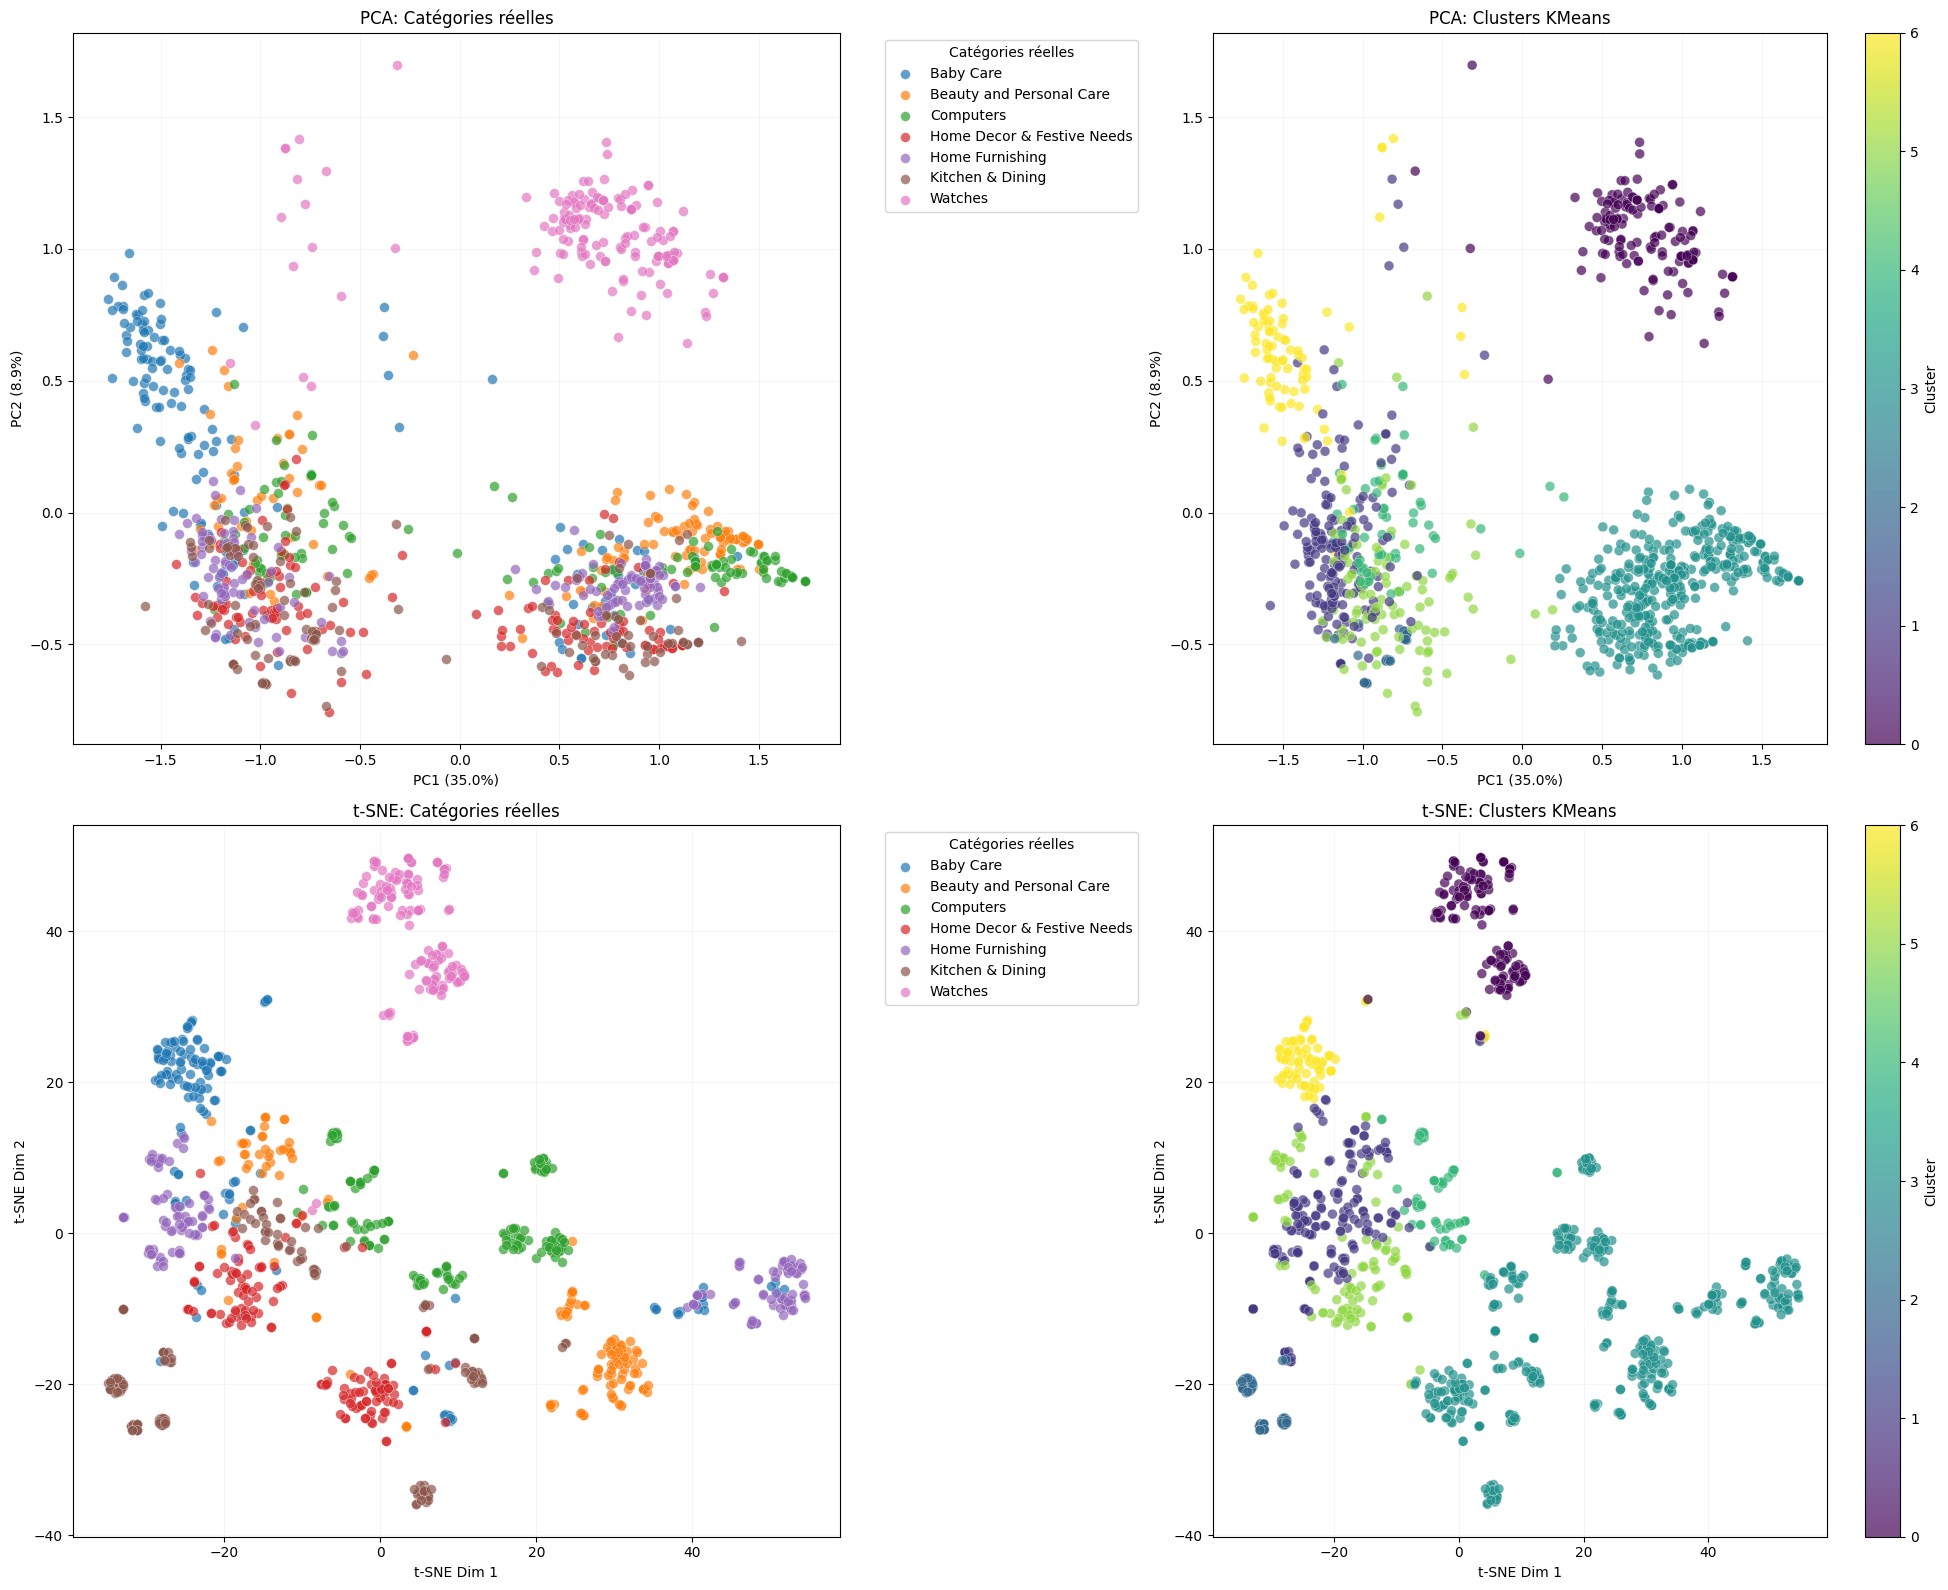


📋 MATRICE DE CONTINGENCE (brute) :
Cluster                       0   1   2    3   4   5   6
Catégorie Réelle                                        
Baby Care                     1  26   1   34   0   7  81
Beauty and Personal Care      0  33   0  101   4  12   0
Computers                     0   1   0   90  59   0   0
Home Decor & Festive Needs    0  31   0   74   1  44   0
Home Furnishing               0  49   0   74   0  27   0
Kitchen & Dining              0  35  46   50   1  18   0
Watches                     137   5   0    0   1   3   4

📊 MATRICE DE CONTINGENCE (% par catégorie) :
col_0                           0      1      2      3      4      5      6
category                                                                   
Baby Care                    0.7%  17.3%   0.7%  22.7%   0.0%   4.7%  54.0%
Beauty and Personal Care     0.0%  22.0%   0.0%  67.3%   2.7%   8.0%   0.0%
Computers                    0.0%   0.7%   0.0%  60.0%  39.3%   0.0%   0.0%
Home Decor & Festive Need

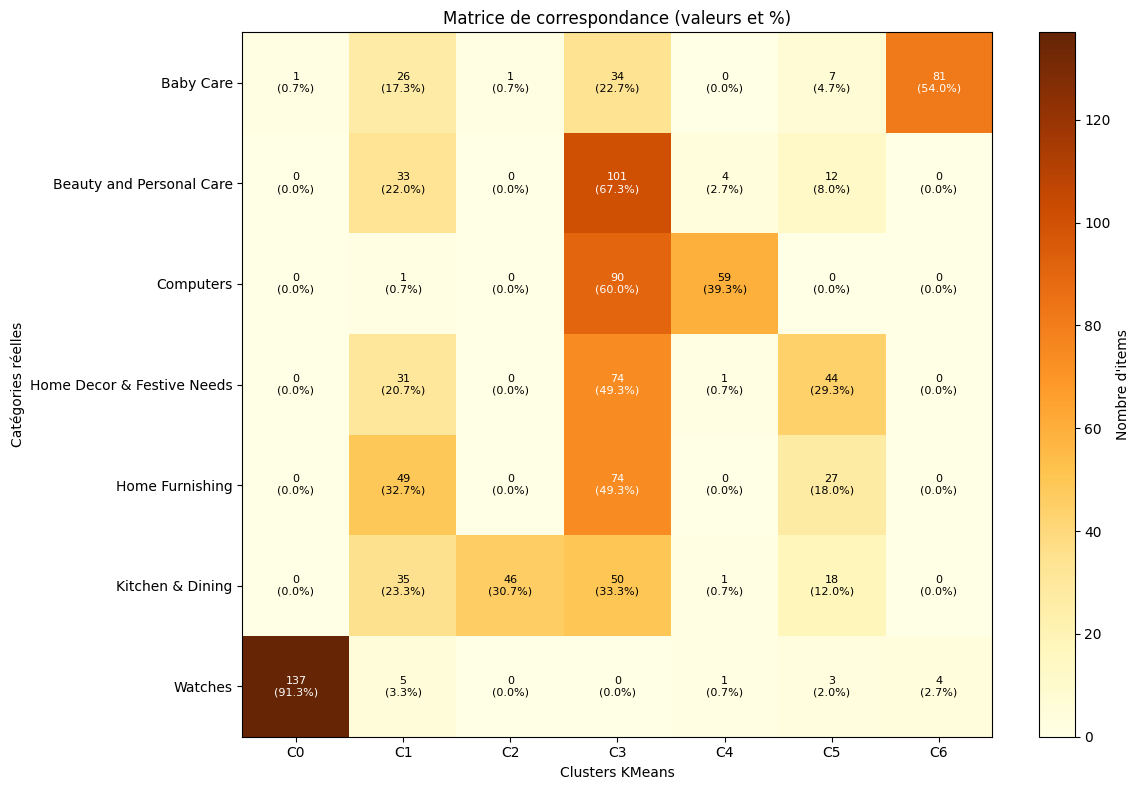


💾 Résultats détaillés sauvegardés ➜ 'clustering_analysis_results.csv'

🎯 ANALYSE TERMINÉE AVEC SUCCÈS !


In [26]:
results = run_pipeline(df)

In [27]:
"""
Pipeline complet et propre pour :
1) entraîner Word2Vec à partir de df['lemmas'] (liste de listes de mots)
2) agréger des embeddings par document (moyenne)
3) clusteriser (KMeans) et évaluer (ARI si df['category'] existe)
4) projeter (PCA & t-SNE) et tracer
5) produire matrices de contingence et exporter les résultats

Pré-requis colonnes du DataFrame :
- df['lemmas'] : list[list[str]]  (tokens lemmatisés par document)
- df['category'] : optionnel (catégorie vraie)

Exemple d'appel :
    results_word2vec = run_pipeline(df)
    # DataFrame prêt à concaténer :
    w2v_df = results_word2vec["results_df"]  # contient doc_id, cluster_label, PCA/t-SNE, true_category (si dispo), model

Le dictionnaire `results_word2vec` retourne :
- 'model' (Word2Vec), 'X' (np.ndarray), 'kmeans', 'cluster_labels',
- 'ari' (ou None), 'interpretation' (ou None),
- 'pca' (objet), 'pca_coords', 'tsne_coords',
- 'contingency_table', 'contingency_pct' (ou None),
- 'results_df' (<< NOUVEAU pour concaténer facilement >>),
- chemins des fichiers écrits.
"""
from __future__ import annotations

import warnings
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt


# ===============================
# 0) CONFIGURATION
# ===============================
@dataclass
class Config:
    # Word2Vec
    vector_size: int = 100
    window: int = 5
    min_count: int = 3
    workers: int = 4
    sg: int = 1  # 1 = Skip-gram, 0 = CBOW
    epochs: int = 30

    # KMeans / TSNE
    n_clusters: Optional[int] = None  # si None et 'category' dispo ➜ nb catégories uniques
    random_state: int = 42
    n_init: int = 10
    tsne_perplexity: int = 30
    tsne_iter: int = 1000

    # I/O
    path_fig_projection: str = "comparison_pca_tsne_true_vs_kmeans.png"
    path_fig_contingency: str = "contingency_matrix_detailed.png"
    path_csv_results: str = "clustering_analysis_results.csv"


# ===============================
# 1) OUTILS & VALIDATION
# ===============================

def _check_dataframe(df: pd.DataFrame) -> None:
    if 'lemmas' not in df.columns:
        raise ValueError("Le DataFrame doit contenir une colonne 'lemmas' (listes de tokens par document).")
    # Vérif rapide du premier élément
    if len(df) == 0:
        raise ValueError("Le DataFrame est vide.")
    sample = df['lemmas'].iloc[0]
    if not isinstance(sample, (list, tuple)):
        raise TypeError("df['lemmas'] doit contenir des listes de chaînes (tokens).")


def _info_head(df: pd.DataFrame) -> None:
    print("🔍 Vérification des données…")
    print(f"Nombre de lignes : {len(df)}")
    try:
        print("Exemple de lemmas :", df['lemmas'].iloc[0][:5])
    except Exception:
        print("Impossible d'afficher un exemple de lemmas.")


# ===============================
# 2) WORD2VEC & FEATURES DOCUMENTAIRES
# ===============================

def train_word2vec(sentences, cfg: Config) -> Word2Vec:
    print("\n🛠 Entraînement du modèle Word2Vec…")
    model = Word2Vec(
        sentences=sentences,
        vector_size=cfg.vector_size,
        window=cfg.window,
        min_count=cfg.min_count,
        workers=cfg.workers,
        sg=cfg.sg,
        epochs=cfg.epochs,
    )
    print("\n🔎 Exploration rapide du modèle :")
    print(f"Taille du vocabulaire : {len(model.wv.key_to_index)} mots")
    return model


def document_vector(model: Word2Vec, doc) -> np.ndarray:
    """Moyenne des vecteurs de mots présents dans le vocabulaire du modèle."""
    tokens = [w for w in doc if w in model.wv.key_to_index]
    if not tokens:
        return np.zeros(model.vector_size, dtype=np.float32)
    return np.mean(model.wv[tokens], axis=0)


def build_feature_matrix(sentences, model: Word2Vec) -> np.ndarray:
    print("\n📦 Création des vecteurs document…")
    X = np.array([document_vector(model, doc) for doc in tqdm(sentences, desc="Vecteurs docs")])
    return X


# ===============================
# 3) CLUSTERING & ÉVALUATION
# ===============================

def choose_k(df: pd.DataFrame, cfg: Config) -> Optional[int]:
    if cfg.n_clusters is not None:
        return cfg.n_clusters
    if 'category' in df.columns:
        return int(df['category'].astype(str).nunique())
    return None


def run_kmeans(X: np.ndarray, k: int, cfg: Config) -> Tuple[KMeans, np.ndarray]:
    print(f"\n🧭 KMeans avec k={k}…")
    km = KMeans(n_clusters=k, random_state=cfg.random_state, n_init=cfg.n_init)
    labels = km.fit_predict(X)
    return km, labels


def evaluate_ari(true_labels: Optional[pd.Series], cluster_labels: np.ndarray) -> Tuple[Optional[float], Optional[str]]:
    if true_labels is None:
        return None, None
    y_true = true_labels.astype(str)
    ari = adjusted_rand_score(y_true, cluster_labels)
    if ari > 0.7:
        interpretation = "EXCELLENT - Structure très bien capturée"
    elif ari > 0.4:
        interpretation = "BON - Structure globalement capturée, quelques confusions"
    else:
        interpretation = "FAIBLE - Structure insuffisamment capturée"
    print(f"\n📊 Adjusted Rand Index (ARI) : {ari:.3f}\n   Interprétation : {interpretation}")
    return ari, interpretation


# ===============================
# 4) RÉDUCTION DE DIMENSION & TRACES
# ===============================

def reduce_dimensions(X: np.ndarray, cfg: Config):
    print("\n🔻 Réduction de dimension : PCA & t-SNE…")
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    print(f"   Variance conservée par la PCA : {pca.explained_variance_ratio_.sum():.1%}")

    # t-SNE peut générer des warnings selon l'échelle ; on les calme légèrement
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, random_state=42, perplexity=cfg.tsne_perplexity, max_iter=cfg.tsne_iter)
        tsne_coords = tsne.fit_transform(X)
    return pca, pca_coords, tsne_coords


def plot_projections(pca, pca_coords, tsne_coords, true_labels, cluster_labels, cfg: Config):
    print("\n📊 Visualisation des projections (PCA / t-SNE)…")
    has_true = true_labels is not None

    plt.figure(figsize=(20, 16))

    # PCA - Vraies catégories (si dispo)
    if has_true:
        plt.subplot(2, 2, 1)
        cats = np.unique(true_labels)
        colors_true = plt.cm.tab10.colors[: len(cats)]
        color_map = {c: colors_true[i] for i, c in enumerate(cats)}
        for c in cats:
            idx = (true_labels == c)
            plt.scatter(pca_coords[idx, 0], pca_coords[idx, 1], s=50, alpha=0.7, edgecolor='white', linewidth=0.3, color=color_map[c], label=str(c))
        plt.legend(title="Catégories réelles", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('PCA: Catégories réelles')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.grid(alpha=0.1)

    # PCA - Clusters
    plt.subplot(2, 2, 2 if has_true else 1)
    sc1 = plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=cluster_labels, cmap=plt.cm.viridis, s=50, alpha=0.7, edgecolor='white', linewidth=0.3)
    plt.colorbar(sc1, label='Cluster')
    plt.title('PCA: Clusters KMeans')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.grid(alpha=0.1)

    # t-SNE - Vraies catégories (si dispo)
    if has_true:
        plt.subplot(2, 2, 3)
        cats = np.unique(true_labels)
        colors_true = plt.cm.tab10.colors[: len(cats)]
        color_map = {c: colors_true[i] for i, c in enumerate(cats)}
        for c in cats:
            idx = (true_labels == c)
            plt.scatter(tsne_coords[idx, 0], tsne_coords[idx, 1], s=50, alpha=0.7, edgecolor='white', linewidth=0.3, color=color_map[c], label=str(c))
        plt.legend(title="Catégories réelles", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('t-SNE: Catégories réelles')
        plt.xlabel('t-SNE Dim 1')
        plt.ylabel('t-SNE Dim 2')
        plt.grid(alpha=0.1)

    # t-SNE - Clusters
    plt.subplot(2, 2, 4 if has_true else 2)
    sc2 = plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=cluster_labels, cmap=plt.cm.viridis, s=50, alpha=0.7, edgecolor='white', linewidth=0.3)
    plt.colorbar(sc2, label='Cluster')
    plt.title('t-SNE: Clusters KMeans')
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.grid(alpha=0.1)

    plt.tight_layout()
    plt.savefig(cfg.path_fig_projection, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


# ===============================
# 5) MATRICE DE CONTINGENCE & HEATMAP
# ===============================

def build_contingency(true_labels: pd.Series, cluster_labels: np.ndarray):
    contingency_table = pd.crosstab(index=true_labels.astype(str), columns=cluster_labels, rownames=['Catégorie Réelle'], colnames=['Cluster'])
    contingency_pct = pd.crosstab(index=true_labels.astype(str), columns=cluster_labels, normalize='index')
    return contingency_table, contingency_pct


def plot_contingency_heatmap(contingency_table: pd.DataFrame, contingency_pct: pd.DataFrame, cfg: Config):
    import matplotlib.ticker as mticker

    plt.figure(figsize=(12, 8))
    plt.imshow(contingency_table.values, cmap='YlOrBr', aspect='auto')

    for i in range(contingency_table.shape[0]):
        for j in range(contingency_table.shape[1]):
            val = contingency_table.iloc[i, j]
            pct = contingency_pct.iloc[i, j] * 100
            color = 'white' if val > contingency_table.values.max() / 2 else 'black'
            plt.text(j, i, f"{val}\n({pct:.1f}%)", ha='center', va='center', fontsize=8, color=color)

    plt.xticks(range(contingency_table.shape[1]), [f'C{j}' for j in range(contingency_table.shape[1])])
    plt.yticks(range(contingency_table.shape[0]), list(contingency_table.index))
    plt.xlabel('Clusters KMeans')
    plt.ylabel('Catégories réelles')
    plt.title('Matrice de correspondance (valeurs et %)')
    cbar = plt.colorbar(label="Nombre d'items")
    cbar.formatter = mticker.ScalarFormatter()
    cbar.update_ticks()
    plt.tight_layout()
    plt.savefig(cfg.path_fig_contingency, dpi=300, bbox_inches='tight')
    plt.show()


# ===============================
# 6) EXPORTS (⚠️ MODIFIÉ POUR RETOURNER UN DATAFRAME)
# ===============================

def export_results(true_labels: Optional[pd.Series],
                   cluster_labels: np.ndarray,
                   pca_coords: np.ndarray,
                   tsne_coords: np.ndarray,
                   cfg: Config,
                   model_name: str = "Word2Vec") -> pd.DataFrame:
    """
    NOUVEAU : renvoie un DataFrame 'results_df' indépendant,
    prêt à être concaténé avec d'autres modèles.
    """
    n = len(cluster_labels)
    doc_id = np.arange(n)  # identifiant de ligne pour concat facile

    results_df = pd.DataFrame({
        'doc_id': doc_id,
        'cluster_label': cluster_labels,
        'pca_x': pca_coords[:, 0],
        'pca_y': pca_coords[:, 1],
        'tsne_x': tsne_coords[:, 0],
        'tsne_y': tsne_coords[:, 1],
        'model': model_name
    })

    if true_labels is not None:
        results_df['true_category'] = true_labels.astype(str).values

    # Export CSV (inchangé)
    results_df.to_csv(cfg.path_csv_results, index=False)
    print(f"\n💾 Résultats détaillés sauvegardés ➜ '{cfg.path_csv_results}'")
    return results_df


# ===============================
# 7) PIPELINE ORCHESTRATEUR
# ===============================

def run_pipeline(df: pd.DataFrame, cfg: Optional[Config] = None) -> Dict:
    cfg = cfg or Config()

    _check_dataframe(df)
    _info_head(df)

    sentences = df['lemmas'].tolist()

    # 2) Word2Vec
    model = train_word2vec(sentences, cfg)

    # 3) Features doc
    X = build_feature_matrix(sentences, model)
    df['word2vec_features'] = list(X)

    # 4) Clustering
    k = choose_k(df, cfg)
    if k is None:
        raise ValueError("Nombre de clusters non déterminé : définissez Config.n_clusters ou fournissez df['category'].")
    kmeans, cluster_labels = run_kmeans(X, k, cfg)

    # 5) Évaluation
    true_labels = df['category'] if 'category' in df.columns else None
    ari, interpretation = evaluate_ari(true_labels, cluster_labels)

    # 6) Réductions & tracés
    pca, pca_coords, tsne_coords = reduce_dimensions(X, cfg)
    plot_projections(pca, pca_coords, tsne_coords, true_labels.astype(str) if true_labels is not None else None, cluster_labels, cfg)

    # 7) Contingence
    contingency_table = contingency_pct = None
    if true_labels is not None:
        contingency_table, contingency_pct = build_contingency(true_labels, cluster_labels)
        print("\n📋 MATRICE DE CONTINGENCE (brute) :")
        print(contingency_table)
        print("\n📊 MATRICE DE CONTINGENCE (% par catégorie) :")
        print((contingency_pct * 100).round(1).astype(str) + "%")
        plot_contingency_heatmap(contingency_table, contingency_pct, cfg)

    # 8) Exports → ⚠️ on récupère le DataFrame indépendant
    results_df = export_results(true_labels, cluster_labels, pca_coords, tsne_coords, cfg, model_name="Word2Vec")

    print("\n🎯 ANALYSE TERMINÉE AVEC SUCCÈS !")

    return {
        'model': model,
        'X': X,
        'kmeans': kmeans,
        'cluster_labels': cluster_labels,
        'ari': ari,
        'interpretation': interpretation,
        'pca': pca,
        'pca_coords': pca_coords,
        'tsne_coords': tsne_coords,
        'contingency_table': contingency_table,
        'contingency_pct': contingency_pct,
        'results_df': results_df,   # <<— NOUVEAU pour concaténer facilement
        'paths': {
            'projection_figure': cfg.path_fig_projection,
            'contingency_figure': cfg.path_fig_contingency,
            'results_csv': cfg.path_csv_results,
        },
    }



🔍 Vérification des données…
Nombre de lignes : 1050
Exemple de lemmas : ['key', 'feature', 'elegance', 'polyester', 'multicolor']

🛠 Entraînement du modèle Word2Vec…

🔎 Exploration rapide du modèle :
Taille du vocabulaire : 2248 mots

📦 Création des vecteurs document…


Vecteurs docs: 100%|█████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 4267.64it/s]



🧭 KMeans avec k=7…

📊 Adjusted Rand Index (ARI) : 0.292
   Interprétation : FAIBLE - Structure insuffisamment capturée

🔻 Réduction de dimension : PCA & t-SNE…
   Variance conservée par la PCA : 44.1%

📊 Visualisation des projections (PCA / t-SNE)…


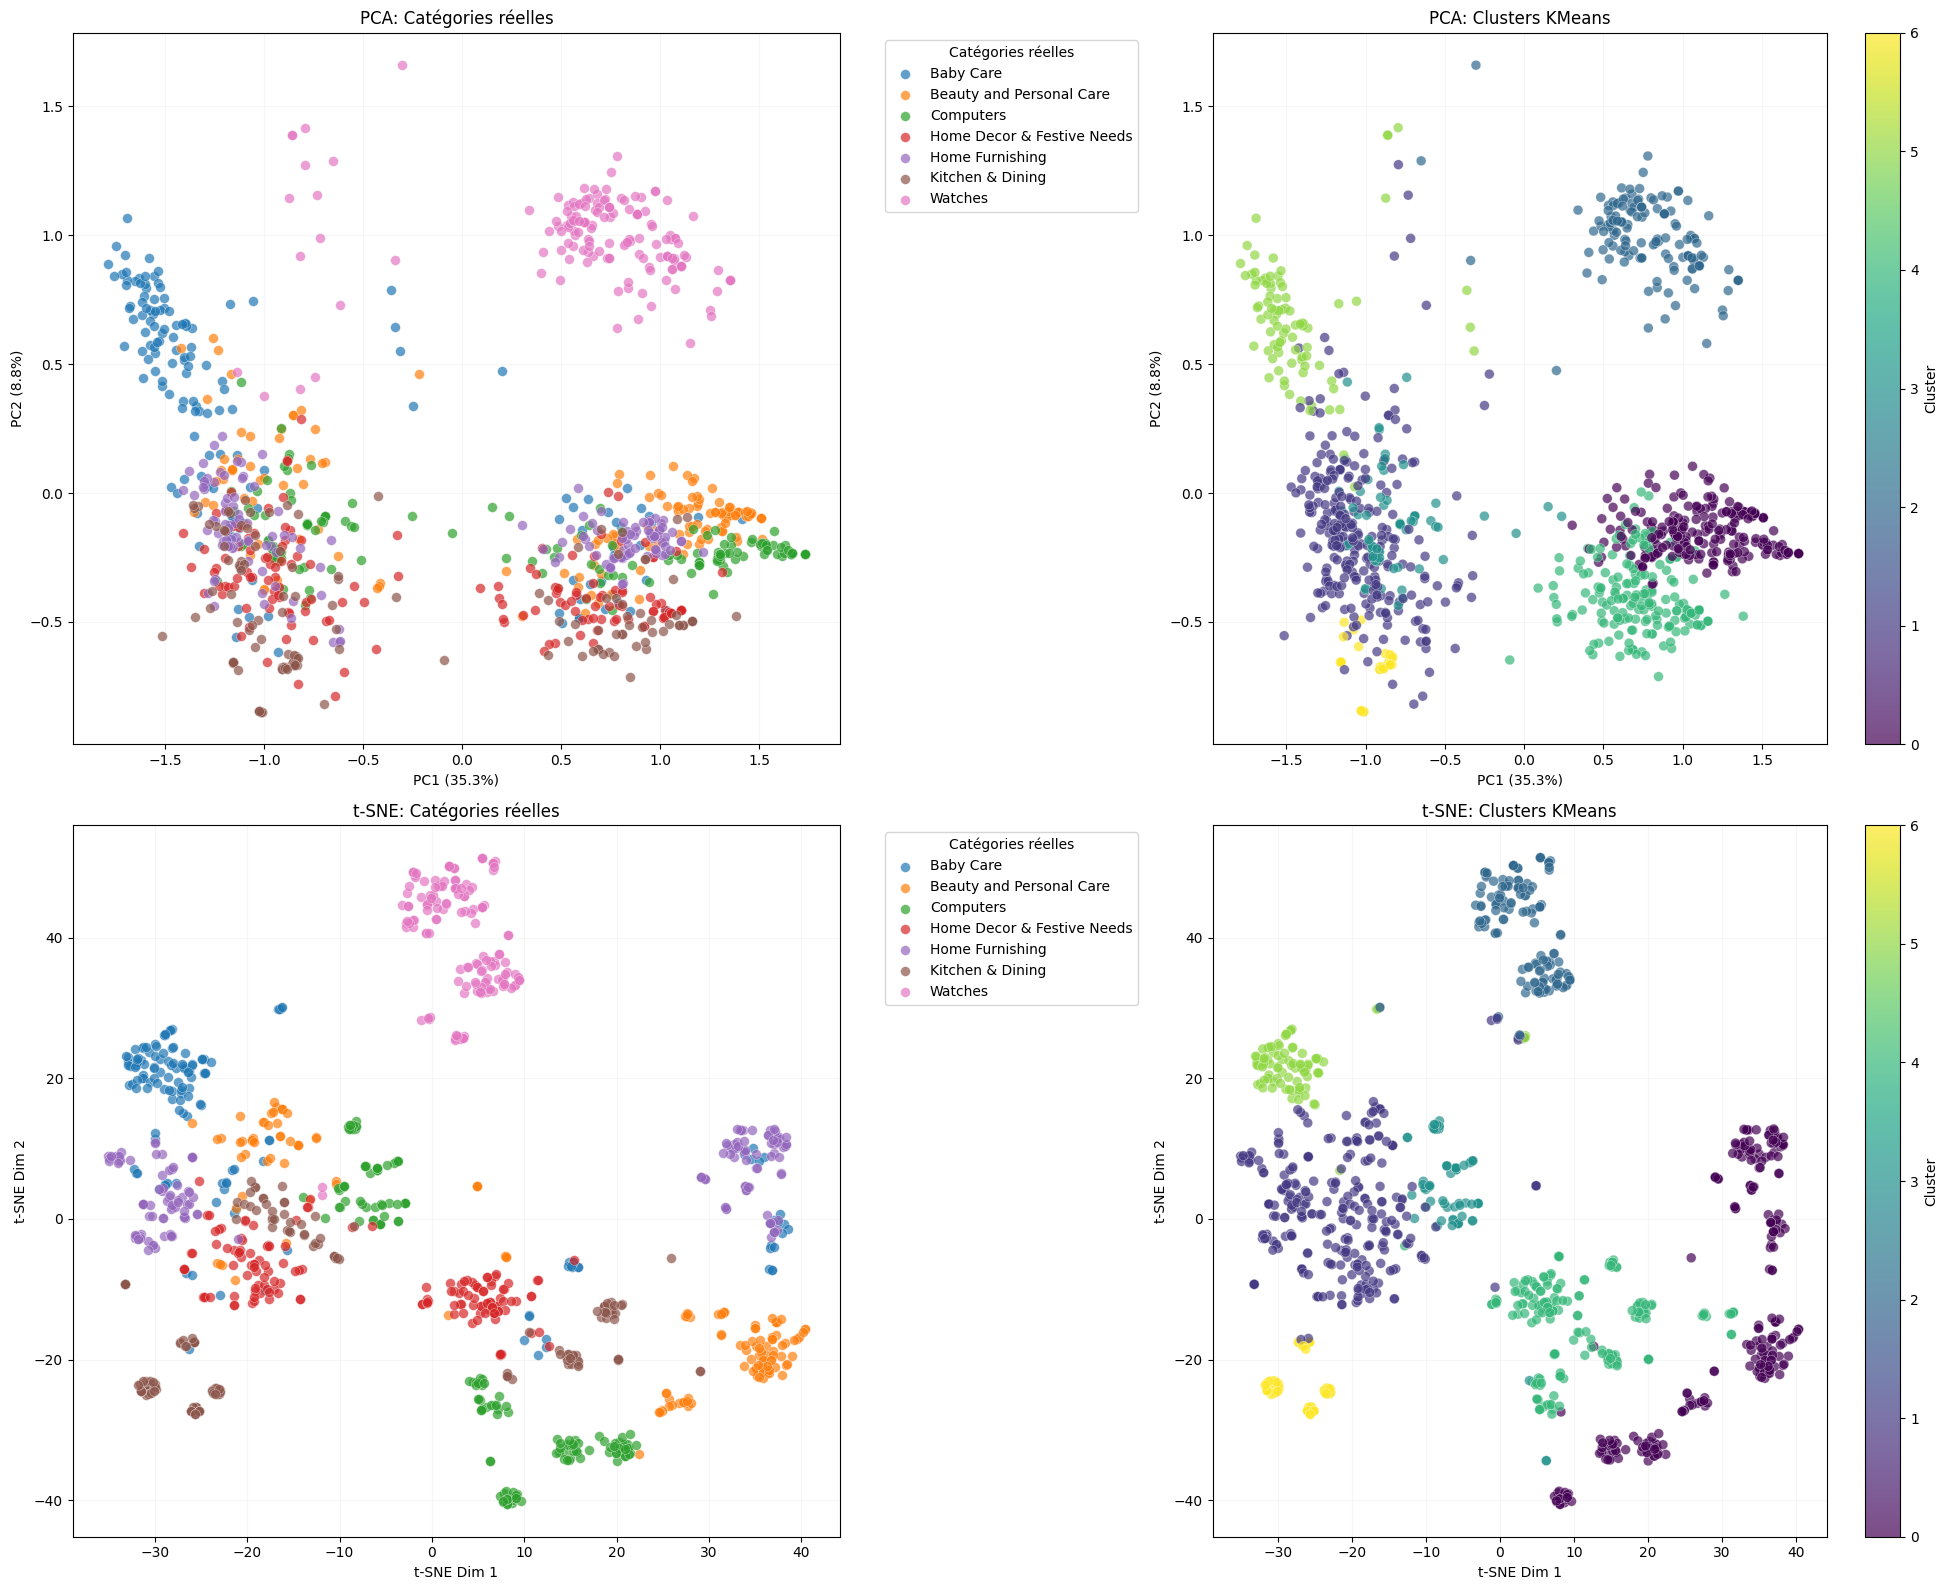


📋 MATRICE DE CONTINGENCE (brute) :
Cluster                      0   1    2   3   4   5   6
Catégorie Réelle                                       
Baby Care                   20  30    1   0  14  84   1
Beauty and Personal Care    80  45    0   4  21   0   0
Computers                   68   2    0  58  22   0   0
Home Decor & Festive Needs   1  73    0   1  75   0   0
Home Furnishing             74  76    0   0   0   0   0
Kitchen & Dining             3  45    0   1  48   0  53
Watches                      0   8  137   1   0   4   0

📊 MATRICE DE CONTINGENCE (% par catégorie) :
col_0                           0      1      2      3      4      5      6
category                                                                   
Baby Care                   13.3%  20.0%   0.7%   0.0%   9.3%  56.0%   0.7%
Beauty and Personal Care    53.3%  30.0%   0.0%   2.7%  14.0%   0.0%   0.0%
Computers                   45.3%   1.3%   0.0%  38.7%  14.7%   0.0%   0.0%
Home Decor & Festive Needs   0.7% 

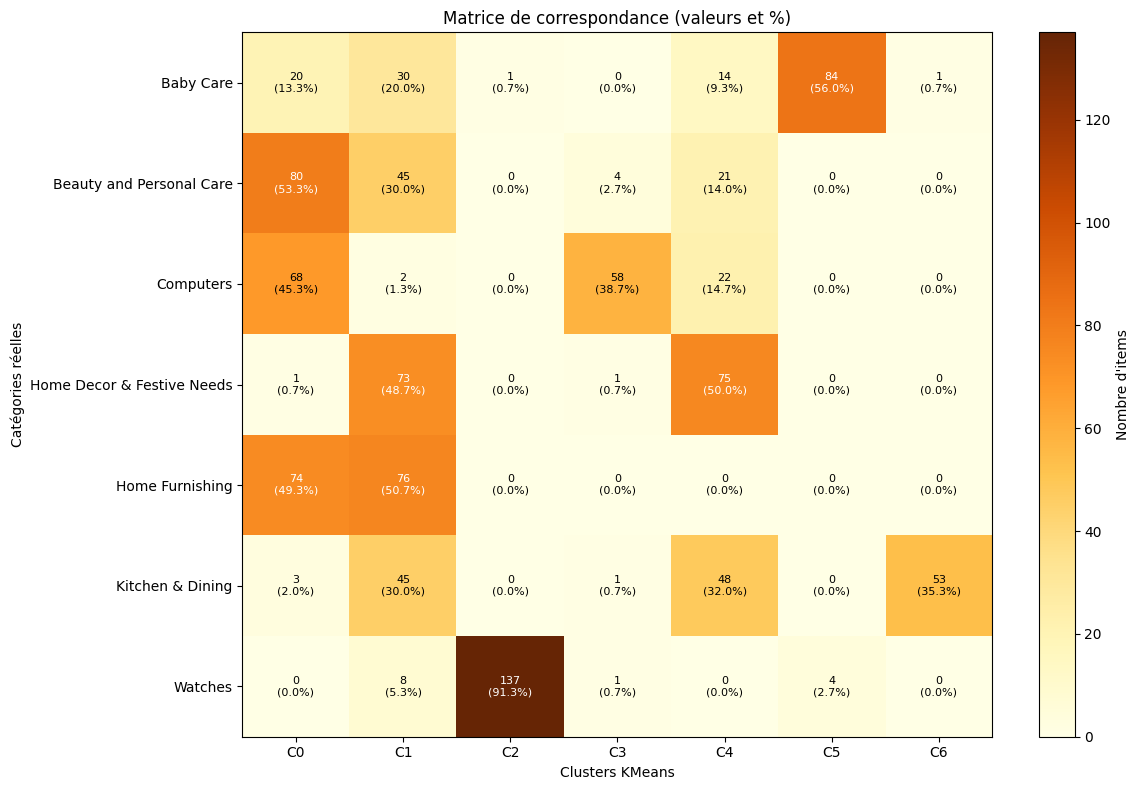


💾 Résultats détaillés sauvegardés ➜ 'clustering_analysis_results.csv'

🎯 ANALYSE TERMINÉE AVEC SUCCÈS !


In [28]:
# appel 
results_word2vec = run_pipeline(df)
w2v_df = results_word2vec["results_df"]
# # plus tard : pd.concat([w2v_df, bert_df], ignore_index=True)


## bert 

In [29]:
from __future__ import annotations
import warnings
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch

# ===============================
# 0) CONFIGURATION
# ===============================
@dataclass
class ConfigBERT:
    model_name: str = "distilbert-base-uncased"
    max_length: int = 128
    batch_size: int = 32
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # KMeans / TSNE
    n_clusters: Optional[int] = None
    random_state: int = 42
    n_init: int = 10
    tsne_perplexity: int = 30
    tsne_iter: int = 1000

    # I/O
    path_fig_projection: str = "bert_comparison_pca_tsne.png"
    path_fig_contingency: str = "bert_contingency_matrix.png"
    path_csv_results: str = "bert_clustering_results.csv"

# ===============================
# 1) UTILITAIRES
# ===============================
def _check_dataframe(df: pd.DataFrame) -> None:
    if 'lemmas' not in df.columns:
        raise ValueError("Le DataFrame doit contenir une colonne 'lemmas'.")
    if len(df) == 0:
        raise ValueError("Le DataFrame est vide.")
    sample = df['lemmas'].iloc[0]
    if not isinstance(sample, (list, tuple)):
        raise TypeError("df['lemmas'] doit contenir des listes de chaînes.")

def _info_head(df: pd.DataFrame) -> None:
    print("🔍 Vérification des données…")
    print(f"Nombre de lignes : {len(df)}")
    try:
        print("Exemple de lemmas :", df['lemmas'].iloc[0][:5])
    except Exception:
        print("Impossible d'afficher un exemple de lemmas.")

# ===============================
# 2) EMBEDDINGS BERT
# ===============================
def compute_bert_embeddings(df: pd.DataFrame, cfg: ConfigBERT):
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    model = AutoModel.from_pretrained(cfg.model_name).to(cfg.device)
    model.eval()

    sentences = df['lemmas'].apply(lambda x: " ".join(x)).tolist()
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), cfg.batch_size), desc="BERT embeddings"):
            batch = sentences[i:i+cfg.batch_size]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=cfg.max_length, return_tensors="pt")
            encoded = {k: v.to(cfg.device) for k, v in encoded.items()}
            outputs = model(**encoded)
            # Moyenne sur les tokens (mean pooling)
            last_hidden = outputs.last_hidden_state
            mask = encoded['attention_mask'].unsqueeze(-1)
            mean_emb = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1)
            embeddings.append(mean_emb.cpu().numpy())

    X = np.vstack(embeddings)
    return model, X

# ===============================
# 3) CLUSTERING & ARI
# ===============================
def choose_k(df: pd.DataFrame, cfg: ConfigBERT) -> Optional[int]:
    if cfg.n_clusters is not None:
        return cfg.n_clusters
    if 'category' in df.columns:
        return int(df['category'].astype(str).nunique())
    return None

def run_kmeans(X: np.ndarray, k: int, cfg: ConfigBERT) -> Tuple[KMeans, np.ndarray]:
    km = KMeans(n_clusters=k, random_state=cfg.random_state, n_init=cfg.n_init)
    labels = km.fit_predict(X)
    return km, labels

def evaluate_ari(true_labels: Optional[pd.Series], cluster_labels: np.ndarray) -> Tuple[Optional[float], Optional[str]]:
    if true_labels is None:
        return None, None
    y_true = true_labels.astype(str)
    ari = adjusted_rand_score(y_true, cluster_labels)
    if ari > 0.7:
        interpretation = "EXCELLENT"
    elif ari > 0.4:
        interpretation = "BON"
    else:
        interpretation = "FAIBLE"
    print(f"\n📊 Adjusted Rand Index (ARI) : {ari:.3f} ({interpretation})")
    return ari, interpretation

# ===============================
# 4) RÉDUCTION DE DIMENSION & VISUALISATION
# ===============================
def reduce_dimensions(X: np.ndarray, cfg: ConfigBERT):
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, random_state=cfg.random_state,
                    perplexity=cfg.tsne_perplexity, max_iter=cfg.tsne_iter)
        tsne_coords = tsne.fit_transform(X)
    return pca, pca_coords, tsne_coords

def plot_projections(pca, pca_coords, tsne_coords, true_labels, cluster_labels, cfg: ConfigBERT):
    has_true = true_labels is not None
    plt.figure(figsize=(20,16))
    if has_true:
        plt.subplot(2,2,1)
        cats = np.unique(true_labels)
        colors_true = plt.cm.tab10.colors[:len(cats)]
        color_map = {c: colors_true[i] for i,c in enumerate(cats)}
        for c in cats:
            idx = (true_labels==c)
            plt.scatter(pca_coords[idx,0], pca_coords[idx,1], s=50, alpha=0.7, edgecolor='w', linewidth=0.3, color=color_map[c], label=str(c))
        plt.legend(title="Catégories réelles", bbox_to_anchor=(1.05,1))
        plt.title("PCA - Catégories réelles")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(alpha=0.1)
    plt.subplot(2,2,2 if has_true else 1)
    plt.scatter(pca_coords[:,0], pca_coords[:,1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.3)
    plt.colorbar(label='Cluster')
    plt.title("PCA - Clusters KMeans")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.1)
    if has_true:
        plt.subplot(2,2,3)
        cats = np.unique(true_labels)
        colors_true = plt.cm.tab10.colors[:len(cats)]
        color_map = {c: colors_true[i] for i,c in enumerate(cats)}
        for c in cats:
            idx = (true_labels==c)
            plt.scatter(tsne_coords[idx,0], tsne_coords[idx,1], s=50, alpha=0.7, edgecolor='w', linewidth=0.3, color=color_map[c], label=str(c))
        plt.legend(title="Catégories réelles", bbox_to_anchor=(1.05,1))
        plt.title("t-SNE - Catégories réelles")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.grid(alpha=0.1)
    plt.subplot(2,2,4 if has_true else 2)
    plt.scatter(tsne_coords[:,0], tsne_coords[:,1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.3)
    plt.colorbar(label='Cluster')
    plt.title("t-SNE - Clusters KMeans")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(alpha=0.1)
    plt.tight_layout()
    plt.savefig(cfg.path_fig_projection, dpi=300, bbox_inches='tight')
    plt.show()

# ===============================
# 5) CONTINGENCE
# ===============================
def build_contingency(true_labels: pd.Series, cluster_labels: np.ndarray):
    contingency_table = pd.crosstab(index=true_labels.astype(str), columns=cluster_labels, rownames=['Catégorie réelle'], colnames=['Cluster'])
    contingency_pct = pd.crosstab(index=true_labels.astype(str), columns=cluster_labels, normalize='index')
    return contingency_table, contingency_pct

def plot_contingency_heatmap(contingency_table, contingency_pct, cfg: ConfigBERT):
    import matplotlib.ticker as mticker
    plt.figure(figsize=(12,8))
    plt.imshow(contingency_table.values, cmap='YlOrBr', aspect='auto')
    for i in range(contingency_table.shape[0]):
        for j in range(contingency_table.shape[1]):
            val = contingency_table.iloc[i,j]
            pct = contingency_pct.iloc[i,j]*100
            color='white' if val>contingency_table.values.max()/2 else 'black'
            plt.text(j,i,f"{val}\n({pct:.1f}%)", ha='center', va='center', fontsize=8, color=color)
    plt.xticks(range(contingency_table.shape[1]), [f"C{j}" for j in range(contingency_table.shape[1])])
    plt.yticks(range(contingency_table.shape[0]), list(contingency_table.index))
    plt.xlabel("Clusters KMeans")
    plt.ylabel("Catégories réelles")
    plt.title("Matrice de correspondance (valeurs et %)")
    cbar = plt.colorbar(label="Nombre d'items")
    cbar.formatter = mticker.ScalarFormatter()
    cbar.update_ticks()
    plt.tight_layout()
    plt.savefig(cfg.path_fig_contingency, dpi=300, bbox_inches='tight')
    plt.show()

# ===============================
# 6) EXPORT
# ===============================
def export_results(true_labels, cluster_labels, pca_coords, tsne_coords, cfg: ConfigBERT, model_name="BERT"):
    n = len(cluster_labels)
    results_df = pd.DataFrame({
        'doc_id': np.arange(n),
        'cluster_label': cluster_labels,
        'pca_x': pca_coords[:,0],
        'pca_y': pca_coords[:,1],
        'tsne_x': tsne_coords[:,0],
        'tsne_y': tsne_coords[:,1],
        'model': model_name
    })
    if true_labels is not None:
        results_df['true_category'] = true_labels.astype(str).values
    results_df.to_csv(cfg.path_csv_results, index=False)
    return results_df

# ===============================
# 7) PIPELINE COMPLET
# ===============================
def run_pipeline_bert(df: pd.DataFrame, cfg: Optional[ConfigBERT]=None) -> Dict:
    cfg = cfg or ConfigBERT()
    _check_dataframe(df)
    _info_head(df)

    true_labels = df['category'] if 'category' in df.columns else None

    # Embeddings
    model, X = compute_bert_embeddings(df, cfg)

    # Clustering
    k = choose_k(df, cfg)
    if k is None:
        raise ValueError("Nombre de clusters non déterminé.")
    kmeans, cluster_labels = run_kmeans(X, k, cfg)

    # Évaluation
    ari, interpretation = evaluate_ari(true_labels, cluster_labels)

    summary_df = pd.DataFrame([{
        "model": "BERT",
        "ARI": ari,
        "interpretation": interpretation,
        "n_clusters": k
    }])

    # PCA / t-SNE
    pca, pca_coords, tsne_coords = reduce_dimensions(X, cfg)
    plot_projections(pca, pca_coords, tsne_coords, true_labels.astype(str) if true_labels is not None else None, cluster_labels, cfg)

    # Contingence
    contingency_table = contingency_pct = None
    if true_labels is not None:
        contingency_table, contingency_pct = build_contingency(true_labels, cluster_labels)
        plot_contingency_heatmap(contingency_table, contingency_pct, cfg)

    # Export
    results_df = export_results(true_labels, cluster_labels, pca_coords, tsne_coords, cfg, model_name="BERT")

    return {
        'model': model,
        'X': X,
        'kmeans': kmeans,
        'cluster_labels': cluster_labels,
        'ari': ari,
        'interpretation': interpretation,
        'pca': pca,
        'pca_coords': pca_coords,
        'tsne_coords': tsne_coords,
        'contingency_table': contingency_table,
        'contingency_pct': contingency_pct,
        'results_df': results_df,
        'summary_df': summary_df,
        'paths': {
            'projection_figure': cfg.path_fig_projection,
            'contingency_figure': cfg.path_fig_contingency,
            'results_csv': cfg.path_csv_results
        }
    }


🔍 Vérification des données…
Nombre de lignes : 1050
Exemple de lemmas : ['key', 'feature', 'elegance', 'polyester', 'multicolor']


BERT embeddings: 100%|█████████████████████████████████████████████████████████████████| 33/33 [05:56<00:00, 10.80s/it]



📊 Adjusted Rand Index (ARI) : 0.306 (FAIBLE)


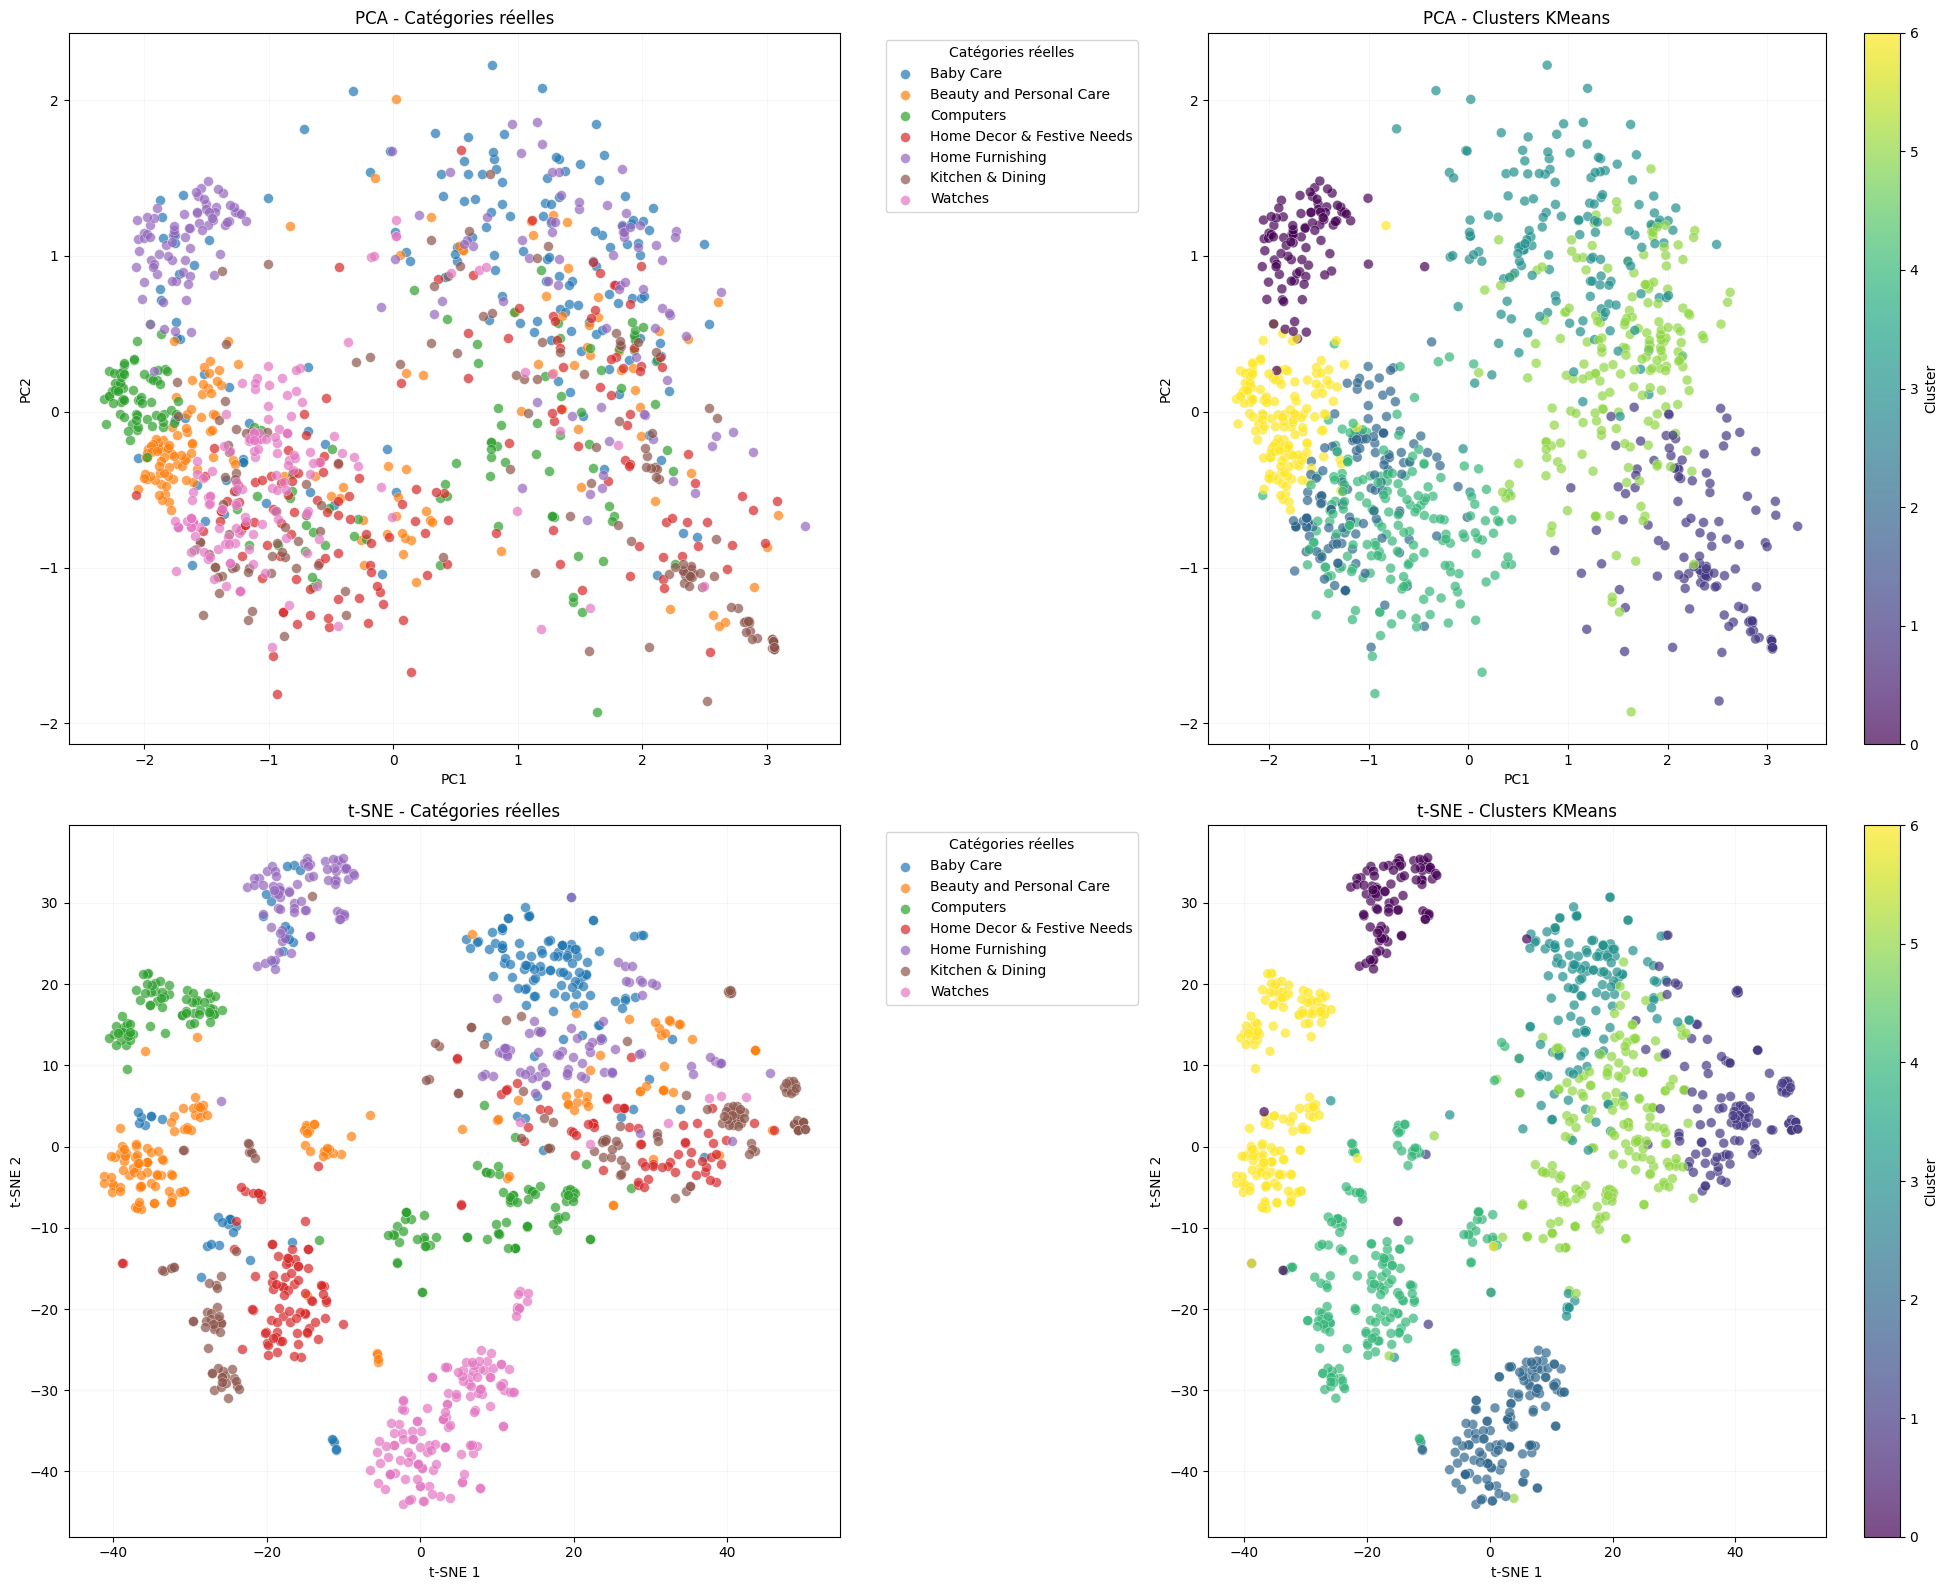

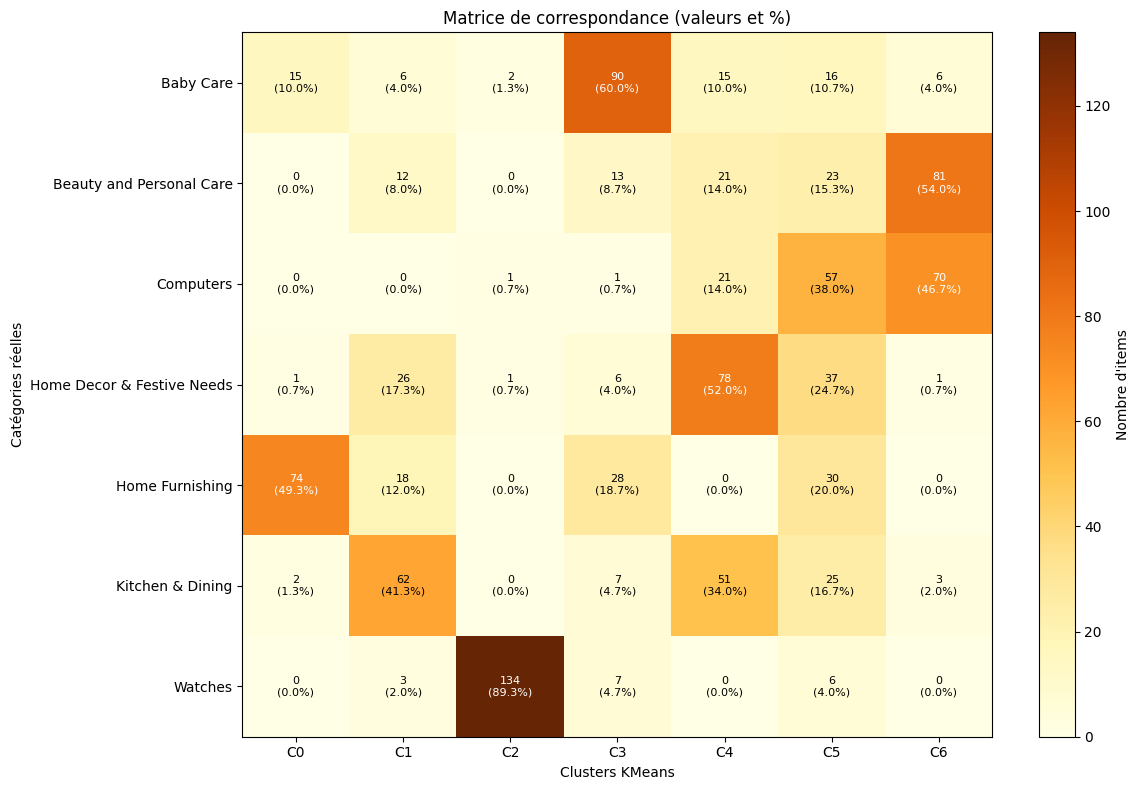

In [30]:
# appell :
results_bert = run_pipeline_bert(df)
bert_df = results_bert["results_df"]

# all_results = pd.concat([w2v_df, bert_df], ignore_index=True)


## USE 

In [31]:
from __future__ import annotations
import os
import warnings
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

import tensorflow as tf
import tensorflow_hub as hub

# ===============================
# CONFIGURATION USE
# ===============================
@dataclass
class ConfigUSE:
    model_url: str = "https://tfhub.dev/google/universal-sentence-encoder/4"
    batch_size: int = 64
    n_clusters: Optional[int] = None
    random_state: int = 42
    n_init: int = 10
    tsne_perplexity: int = 30
    tsne_iter: int = 1000
    path_fig_projection: str = "use_pca_tsne_true_vs_kmeans.png"
    path_fig_contingency: str = "use_contingency_matrix.png"
    path_csv_results: str = "use_clustering_results.csv"


# ===============================
# UTILITAIRES
# ===============================
def _check_dataframe(df: pd.DataFrame) -> None:
    if 'lemmas' not in df.columns:
        raise ValueError("Le DataFrame doit contenir une colonne 'lemmas' (listes de tokens par document).")
    if len(df) == 0:
        raise ValueError("Le DataFrame est vide.")


def _info_head(df: pd.DataFrame) -> None:
    print("🔍 Vérification des données…")
    print(f"Nombre de lignes : {len(df)}")
    try:
        print("Exemple de lemmas :", df['lemmas'].iloc[0][:5])
    except Exception:
        print("Impossible d'afficher un exemple de lemmas.")


# ===============================
# EMBEDDINGS USE
# ===============================
def compute_use_embeddings(df: pd.DataFrame, cfg: ConfigUSE):
    print("\n📦 Chargement du modèle USE…")
    model = hub.load(cfg.model_url)

    sentences = df['lemmas'].apply(lambda x: " ".join(x)).tolist()
    embeddings = []

    print("📦 Encodage par lots...")
    for i in tqdm(range(0, len(sentences), cfg.batch_size)):
        batch = sentences[i:i+cfg.batch_size]
        emb = model(batch)
        embeddings.append(emb.numpy())

    X = np.vstack(embeddings)
    print(f"Forme des embeddings : {X.shape}")
    return model, X


# ===============================
# CLUSTERING & EVALUATION
# ===============================
def choose_k(df: pd.DataFrame, cfg: ConfigUSE) -> Optional[int]:
    if cfg.n_clusters is not None:
        return cfg.n_clusters
    if 'category' in df.columns:
        return int(df['category'].astype(str).nunique())
    return None


def run_kmeans(X: np.ndarray, k: int, cfg: ConfigUSE) -> Tuple[KMeans, np.ndarray]:
    print(f"\n🧭 KMeans avec k={k}…")
    km = KMeans(n_clusters=k, random_state=cfg.random_state, n_init=cfg.n_init)
    labels = km.fit_predict(X)
    return km, labels


def evaluate_ari(true_labels: Optional[pd.Series], cluster_labels: np.ndarray) -> Tuple[Optional[float], Optional[str]]:
    if true_labels is None:
        return None, None
    y_true = true_labels.astype(str)
    ari = adjusted_rand_score(y_true, cluster_labels)
    if ari > 0.7:
        interpretation = "EXCELLENT - Structure très bien capturée"
    elif ari > 0.4:
        interpretation = "BON - Structure globalement capturée, quelques confusions"
    else:
        interpretation = "FAIBLE - Structure insuffisamment capturée"
    print(f"\n📊 Adjusted Rand Index (ARI) : {ari:.3f}\n   Interprétation : {interpretation}")
    return ari, interpretation


# ===============================
# RÉDUCTION DE DIMENSION & TRACES
# ===============================
def reduce_dimensions(X: np.ndarray, cfg: ConfigUSE):
    print("\n🔻 Réduction de dimension : PCA & t-SNE…")
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    print(f"   Variance conservée par la PCA : {pca.explained_variance_ratio_.sum():.1%}")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, random_state=cfg.random_state, perplexity=cfg.tsne_perplexity, max_iter=cfg.tsne_iter)
        tsne_coords = tsne.fit_transform(X)
    return pca, pca_coords, tsne_coords


# Réutiliser les fonctions plot_projections, build_contingency, plot_contingency_heatmap, export_results du code Word2Vec
# Elles restent inchangées

# ===============================
# PIPELINE USE
# ===============================
def run_pipeline_use(df: pd.DataFrame, cfg: Optional[ConfigUSE] = None) -> Dict:
    cfg = cfg or ConfigUSE()
    _check_dataframe(df)
    _info_head(df)

    true_labels = df['category'] if 'category' in df.columns else None

    # Embeddings
    model, X = compute_use_embeddings(df, cfg)

    # Clustering
    k = choose_k(df, cfg)
    if k is None:
        raise ValueError("Nombre de clusters non déterminé : définissez Config.n_clusters ou fournissez df['category'].")
    kmeans, cluster_labels = run_kmeans(X, k, cfg)

    # Évaluation
    ari, interpretation = evaluate_ari(true_labels, cluster_labels)

    # Réduction dimension
    pca, pca_coords, tsne_coords = reduce_dimensions(X, cfg)

    # Traces
    plot_projections(pca, pca_coords, tsne_coords,
                     true_labels.astype(str) if true_labels is not None else None,
                     cluster_labels, cfg)

    # Contingence
    contingency_table = contingency_pct = None
    if true_labels is not None:
        contingency_table, contingency_pct = build_contingency(true_labels, cluster_labels)
        plot_contingency_heatmap(contingency_table, contingency_pct, cfg)

    # Export
    results_df = export_results(true_labels, cluster_labels, pca_coords, tsne_coords, cfg, model_name="USE")

    print("\n🎯 ANALYSE USE TERMINÉE AVEC SUCCÈS !")
    return {
        'model': model,
        'X': X,
        'kmeans': kmeans,
        'cluster_labels': cluster_labels,
        'ari': ari,
        'interpretation': interpretation,
        'pca': pca,
        'pca_coords': pca_coords,
        'tsne_coords': tsne_coords,
        'contingency_table': contingency_table,
        'contingency_pct': contingency_pct,
        'results_df': results_df,
        'paths': {
            'projection_figure': cfg.path_fig_projection,
            'contingency_figure': cfg.path_fig_contingency,
            'results_csv': cfg.path_csv_results,
        },
    }


In [32]:
# APpel  :
results_use = run_pipeline_use(df)
use_df = results_use["results_df"]



🔍 Vérification des données…
Nombre de lignes : 1050
Exemple de lemmas : ['key', 'feature', 'elegance', 'polyester', 'multicolor']

📦 Chargement du modèle USE…


ValueError: Trying to load a model of incompatible/unknown type. 'C:\Users\mario\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [ ]:
all_results = pd.concat([w2v_df, bert_df], ignore_index=True)
all_results

In [ ]:
def collect_ari(results_dict: dict, model_name: str) -> pd.DataFrame:
    """
    Extrait l'ARI d'un pipeline et retourne un DataFrame
    pour comparaison entre modèles.
    """
    ari = results_dict.get("ari", None)
    interpretation = results_dict.get("interpretation", None)

    return pd.DataFrame([{
        "model": model_name,
        "ARI": ari,
        "interpretation": interpretation
    }])


In [ ]:
# --- Word2Vec ---
results_w2v = run_pipeline(df)
ari_w2v_df = collect_ari(results_w2v, "Word2Vec")

# --- BERT ---
results_bert = run_pipeline_bert(df)   # ta version BERT
ari_bert_df = collect_ari(results_bert, "BERT")

# --- USE ---
results_use = run_pipeline_use(df)     # ta version USE
ari_use_df = collect_ari(results_use, "USE")

# Concaténer pour comparer
ari_comparison_df = pd.concat([ari_w2v_df, ari_bert_df, ari_use_df], ignore_index=True)

print("\n📊 Comparaison ARI entre modèles :")
print(ari_comparison_df)


## CE8: Vérification de la propriété intellectuelle : 
linda a bien verrifier que  qu’il n’y avait aucune contrainte de propriété intellectuelle sur les données et les images.